This code is used to mount google drive to google colab.
It allows google colab virtual machine to access all files and folders in google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the verified absolute path
DRIVE_DATA_PATH = '/content/drive/MyDrive/Cognitive_Computing_Exam/data'

Mounted at /content/drive


EDA 1. Count images per class,
We see that there is an imbalance for Gray Leaf spot with 574 images compared to the rest of the images so we shall carry out data augumentation in the data preprocessing steps to generate more images for Gray leaf disease


In [ ]:
import os
from collections import Counter

print("📌 Classes found:")
classes = os.listdir(DRIVE_DATA_PATH)
print(classes)

class_counts = {}

for cls in classes:
    cls_path = os.path.join(DRIVE_DATA_PATH, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

print("\n📊 Image Count per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


📌 Classes found:
['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']

📊 Image Count per Class:
Common_Rust: 1306 images
Healthy: 1162 images
Gray_Leaf_Spot: 574 images
Blight: 1146 images


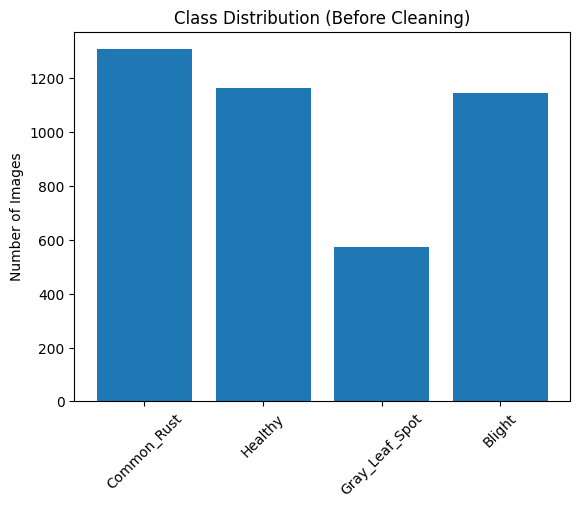

In [ ]:
import matplotlib.pyplot as plt
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Before Cleaning)")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()


EDA 2. Show sample images from each class

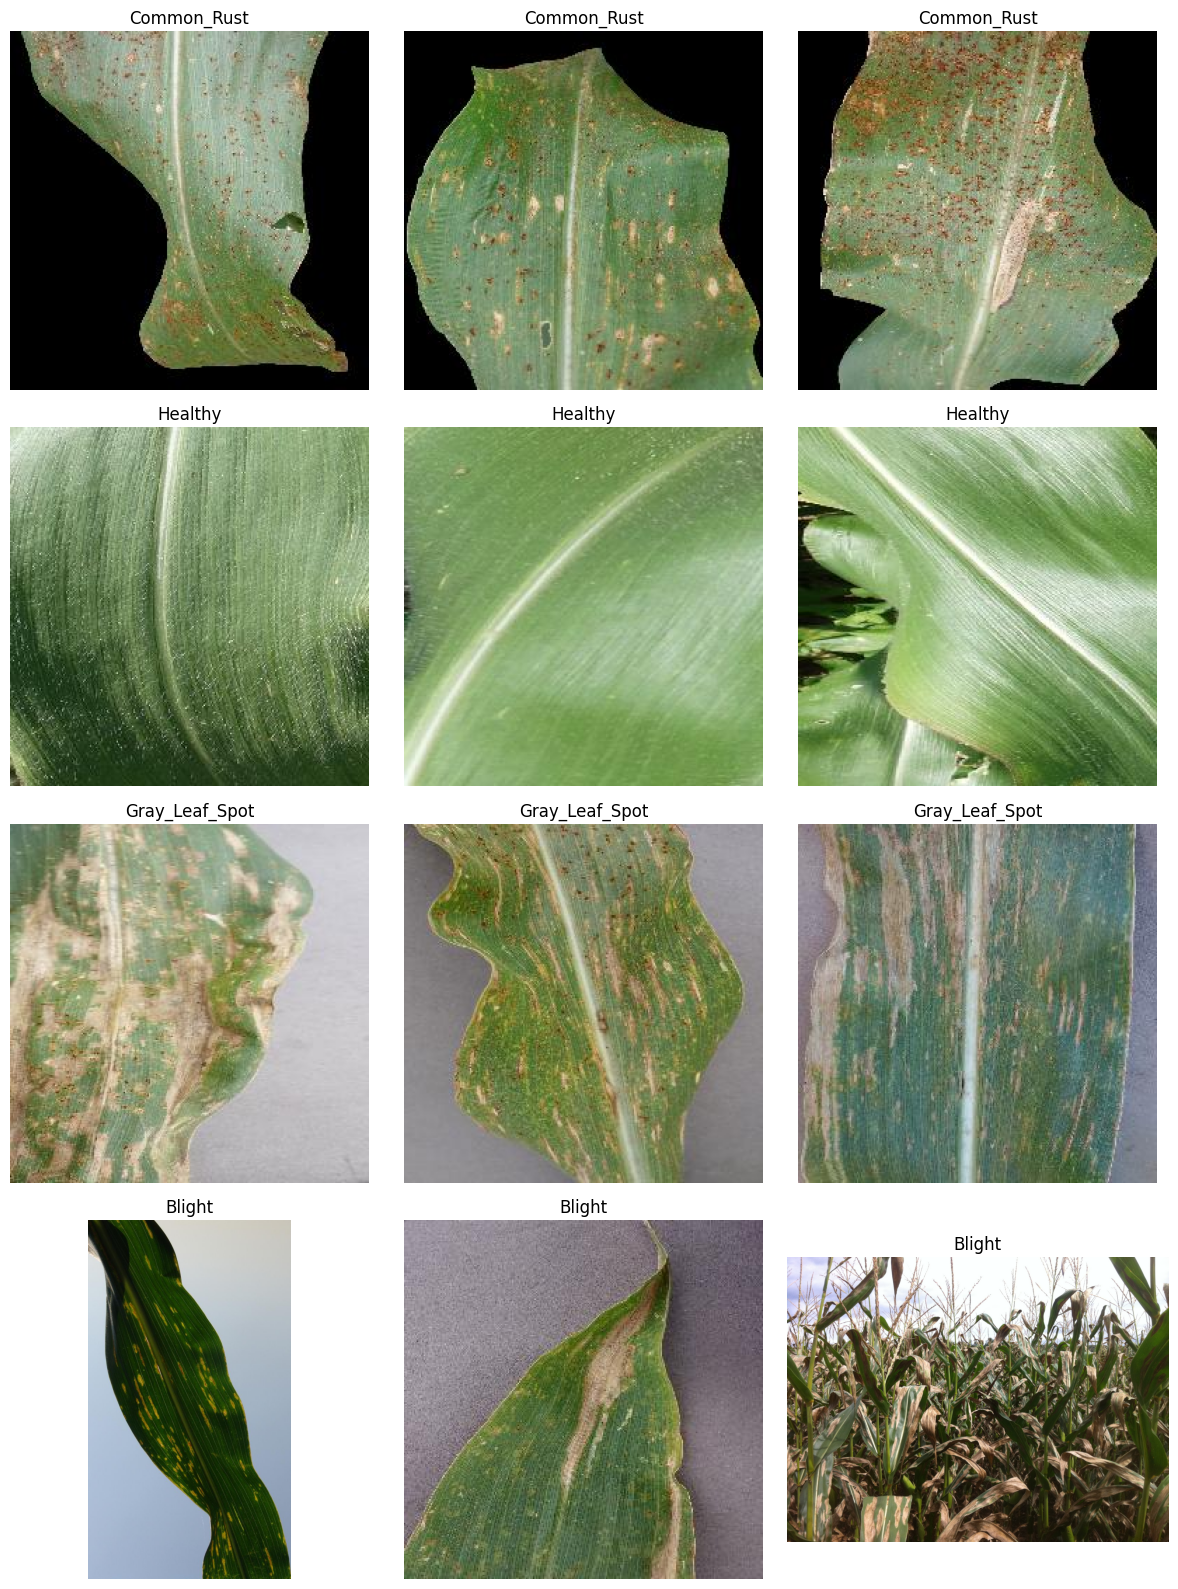

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples_per_class(path, samples=3):
    classes = os.listdir(path)
    plt.figure(figsize=(samples*4, len(classes)*4))
    i = 1

    for cls in classes:
        cls_folder = os.path.join(path, cls)
        images = os.listdir(cls_folder)
        sample_images = random.sample(images, samples)

        for img in sample_images:
            img_path = os.path.join(cls_folder, img)
            image = Image.open(img_path)

            plt.subplot(len(classes), samples, i)
            plt.imshow(image)
            plt.title(cls)
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

show_samples_per_class(DRIVE_DATA_PATH)


Image Size distribution
A distribution analysis of image widths and heights revealed significant variability within the dataset. Most images fall within the 200–800 pixel range; however, a non-negligible number of samples exceed 1000 pixels, with some reaching resolutions above 5000 pixels. This inconsistency has important implications for model development. Large images increase computational load, while extreme variation in aspect ratio and size can distort leaf shapes during resizing. These distortions may degrade the model’s ability to learn fine-grained disease features such as leaf spots, texture, and vein patterns. To mitigate this, all images were standardized to 224×224 pixels during preprocessing using TensorFlow’s ImageDataGenerator. This ensures uniformity in the sensory input layer and improves model stability during training.

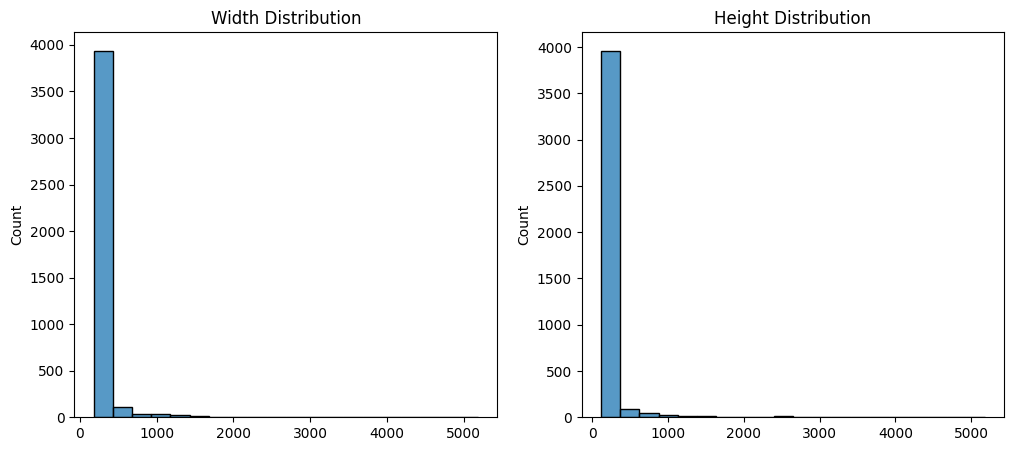

In [ ]:
from PIL import Image

widths, heights = [], []

for cls in os.listdir(DRIVE_DATA_PATH):
    for fname in os.listdir(os.path.join(DRIVE_DATA_PATH, cls)):
        path = os.path.join(DRIVE_DATA_PATH, cls, fname)
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
        except:
            pass

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(widths, bins=20)
plt.title("Width Distribution")

plt.subplot(1,2,2)
sns.histplot(heights, bins=20)
plt.title("Height Distribution")

plt.show()


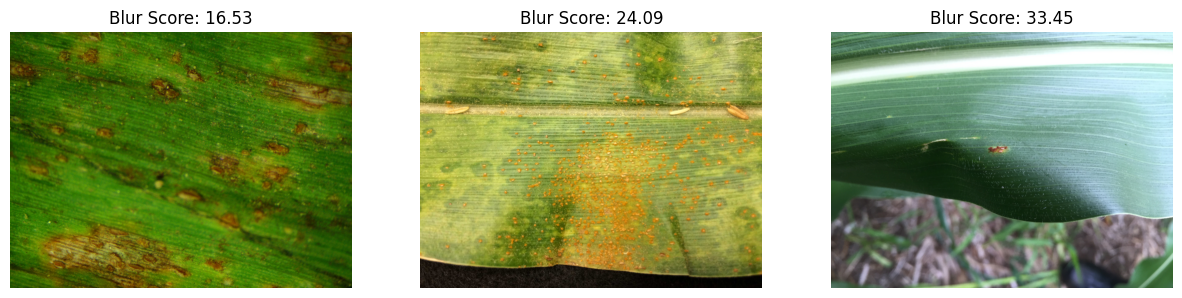

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Example blurry images list (your data)
blurry_images = [
    ('/content/drive/MyDrive/Cognitive_Computing_Exam/data/Common_Rust/Corn_Common_Rust (17).jpg', 16.53),
    ('/content/drive/MyDrive/Cognitive_Computing_Exam/data/Common_Rust/Corn_Common_Rust (8).jpg', 24.09),
    ('/content/drive/MyDrive/Cognitive_Computing_Exam/data/Common_Rust/Corn_Common_Rust (1267).jpg', 33.45),
]

plt.figure(figsize=(15,5))
for i, (img_path, score) in enumerate(blurry_images):
    img = Image.open(img_path)
    plt.subplot(1, len(blurry_images), i+1)
    plt.imshow(img)
    plt.title(f"Blur Score: {score:.2f}")
    plt.axis('off')

plt.show()


Since its only common rust with blury images we shall use data augumentation to generate more clear ones because we would loose alot of common rust images


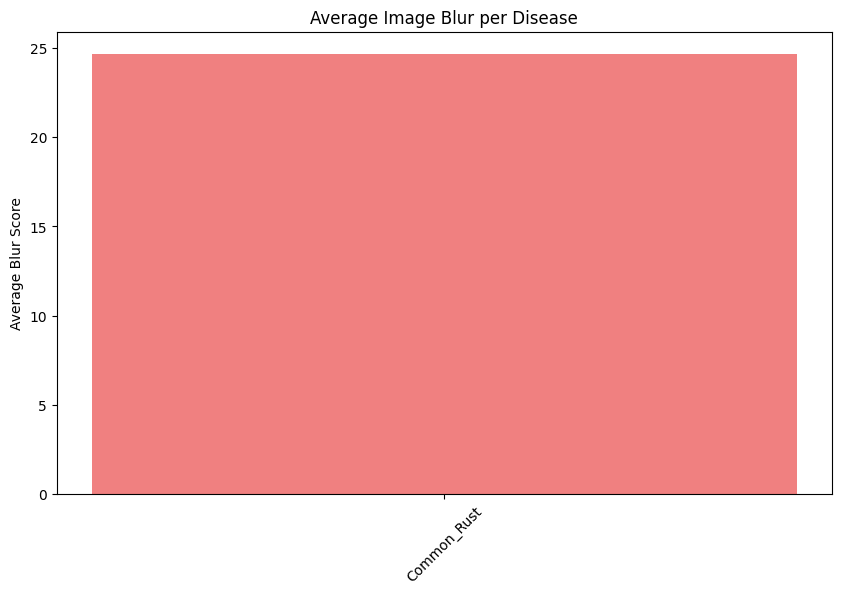

In [ ]:
import numpy as np
from collections import defaultdict

# Suppose blurry_images contains tuples (path, blur_score)
blur_by_disease = defaultdict(list)

for path, score in blurry_images:
    disease_name = path.split('/')[-2]  # folder name is disease
    blur_by_disease[disease_name].append(score)

# Compute average blur
avg_blur = {d: np.mean(scores) for d, scores in blur_by_disease.items()}

# Plot
plt.figure(figsize=(10,6))
plt.bar(avg_blur.keys(), avg_blur.values(), color='lightcoral')
plt.xticks(rotation=45)
plt.ylabel("Average Blur Score")
plt.title("Average Image Blur per Disease")
plt.show()


EDA 3. Check image sizes

In [ ]:
from PIL import Image

widths = []
heights = []

for cls in os.listdir(DRIVE_DATA_PATH):
    cls_path = os.path.join(DRIVE_DATA_PATH, cls)
    for file in os.listdir(cls_path):
        try:
            with Image.open(os.path.join(cls_path, file)) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            print("⚠️ Corrupt image detected:", file)

print("Average width:", sum(widths)/len(widths))
print("Average height:", sum(heights)/len(heights))


Average width: 307.5365329512894
Average height: 297.90616045845275


Checking for Corupt images


In [ ]:
corrupt_images = []

for cls in os.listdir(DRIVE_DATA_PATH):
    cls_path = os.path.join(DRIVE_DATA_PATH, cls)
    for file in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, file))
            img.verify()
        except:
            corrupt_images.append(os.path.join(cls_path, file))

print("Corrupt Images:", corrupt_images)


Corrupt Images: []


Preprocessing and Augumentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the verified absolute path
DRIVE_DATA_PATH = '/content/drive/MyDrive/Cognitive_Computing_Exam/data'

# Initialize the generator and define augmentation/preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserves 20% of images for validation
)

# 1. Recreate Training Data Generator
train_generator = train_datagen.flow_from_directory(
    DRIVE_DATA_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# 2. Recreate Validation Data Generator
validation_generator = train_datagen.flow_from_directory(
    DRIVE_DATA_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("\n✅ Task B1 Generators successfully recreated in memory.")

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.

✅ Task B1 Generators successfully recreated in memory.


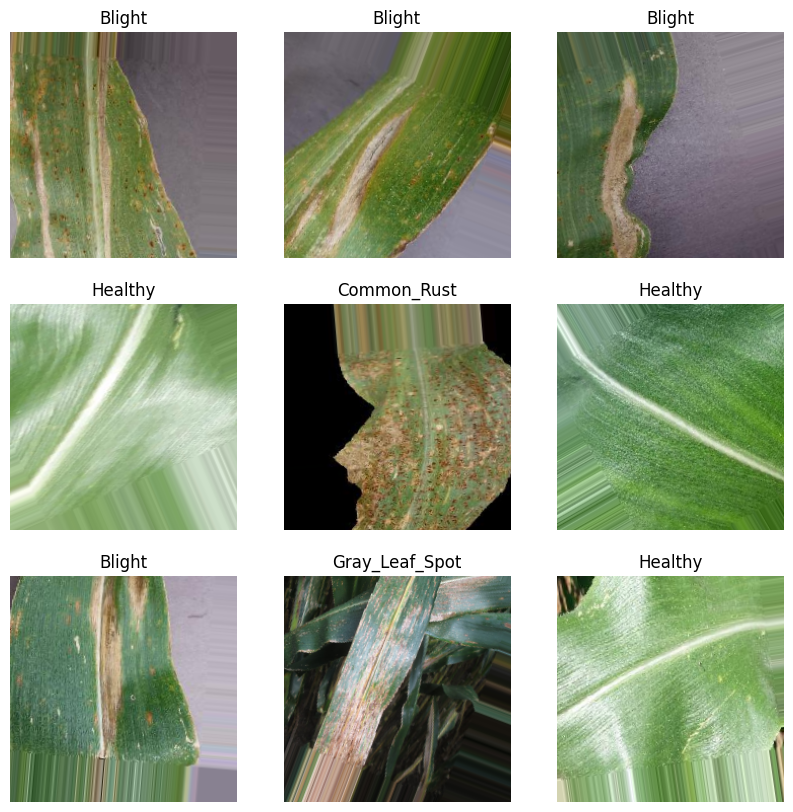

In [ ]:
import matplotlib.pyplot as plt

# Ask the generator for the next batch of data (images and labels)
# The output is a tuple: (batch_of_images, batch_of_labels)
images, labels = next(train_generator)

# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Display the image (it is already scaled 0-1)
    plt.imshow(images[i])

    # Get the corresponding class name from the label array
    # labels[i] is like [0, 1, 0, 0], we find where the 1 is located
    label_index = labels[i].argmax()
    title = class_names[label_index]

    plt.title(title)
    plt.axis("off")
plt.show()

# After plotting, the generator is ready to deliver the next batch when you start training.

MODEL TRAINING THE UNDERSTAND PILLAR

1) MACHINE LEARNING CNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Define constants based on your successful Task B1 setup
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 4

# -----------------------------------------------------------
# Load the Pre-trained Base Model (MobileNetV2)
# -----------------------------------------------------------
# Load MobileNetV2 weights trained on ImageNet, but exclude the top classifier layers
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the weights: The pre-trained layers are kept constant to use their learned features.
base_model.trainable = False

# -----------------------------------------------------------
# Build the New Classification Head (The Understanding Engine)
# -----------------------------------------------------------
model = Sequential([
    # The pre-trained features (frozen)
    base_model,

    # Converts the 3D feature maps into a 1D vector
    GlobalAveragePooling2D(),

    # Dropout to prevent overfitting during the training of the new layers
    Dropout(0.2),

    # Final layer: 4 outputs corresponding to your 4 classes
    Dense(NUM_CLASSES, activation='softmax')
])

print("Model Architecture Summary:")
model.summary()
#

# -----------------------------------------------------------
# 2. Compile and Train the Model
# -----------------------------------------------------------
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Appropriate loss function for multi-class classification
    metrics=['accuracy']
)

print("\nStarting Model Training (The Understanding Engine)...")

# Assuming train_generator and validation_generator are still in memory from Task B1
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# -----------------------------------------------------------
# 3. Save the Trained Model
# -----------------------------------------------------------
model_save_path = '/content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5'
model.save(model_save_path)
print(f"\nModel training complete! Saved trained model to: {model_save_path}")

Model Architecture Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting Model Training (The Understanding Engine)...
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 712ms/step - accuracy: 0.6412 - loss: 0.8800 - val_accuracy: 0.8906 - val_loss: 0.2856
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9062 - loss: 0.3118 - val_accuracy: 0.8978 - val_loss: 0.2713
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 116s 638ms/step - accuracy: 0.8544 - loss: 0.3528 - val_accuracy: 0.8894 - val_loss: 0.2711
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.8750 - loss: 0.3399 - val_accuracy: 0.8930 - val_loss: 0.2731
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 633ms/step - accuracy: 0.8919 - loss: 0.2893 - val_accuracy: 0.9014 - val_loss: 0.2379
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9062 - loss: 0.3346 - val_accuracy: 0.9075 - val_loss: 0.2209
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 636ms/step - accuracy: 0.8893 - loss: 0.2762 - val_accuracy: 0.8954 - val_loss: 0.2432
Epoch 8/10
104/104 ━━━━━━━━


Model training complete! Saved trained model to: /content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5


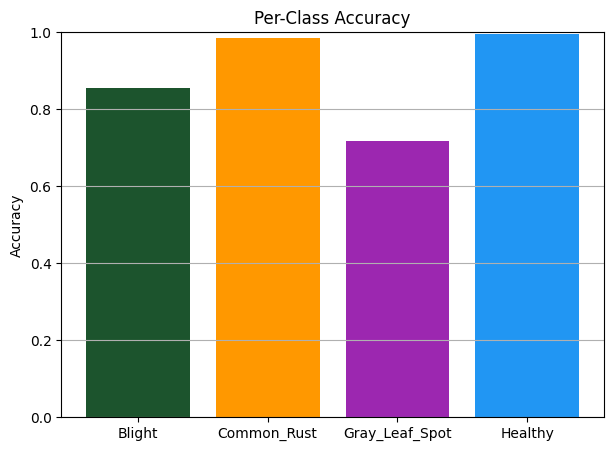

In [ ]:
import numpy as np

class_accuracy = []

for i in range(4):  # 4 classes
    idxs = np.where(np.array(y_true) == i)[0]
    correct = np.sum(np.array(y_pred)[idxs] == i)
    acc = correct / len(idxs)
    class_accuracy.append(acc)

plt.figure(figsize=(7,5))
plt.bar(class_labels, class_accuracy, color=["#1c542d", "#ff9800", "#9c27b0", "#2196f3"])
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()


Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


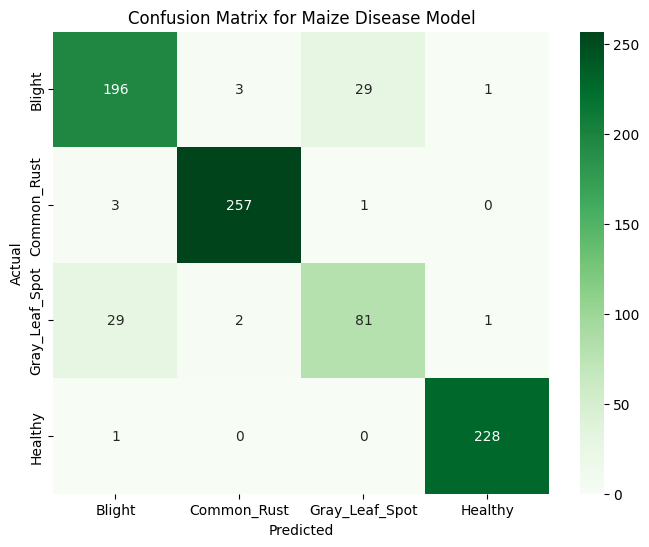


Classification Report:
                precision    recall  f1-score   support

        Blight       0.86      0.86      0.86       229
   Common_Rust       0.98      0.98      0.98       261
Gray_Leaf_Spot       0.73      0.72      0.72       113
       Healthy       0.99      1.00      0.99       229

      accuracy                           0.92       832
     macro avg       0.89      0.89      0.89       832
  weighted avg       0.92      0.92      0.92       832



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Generate predictions
# -----------------------------
val_steps = validation_generator.samples // validation_generator.batch_size

y_true = []
y_pred = []

for i in range(val_steps):
    x_batch, y_batch = next(validation_generator)
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
class_labels = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Maize Disease Model")
plt.show()

# -----------------------------
# Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


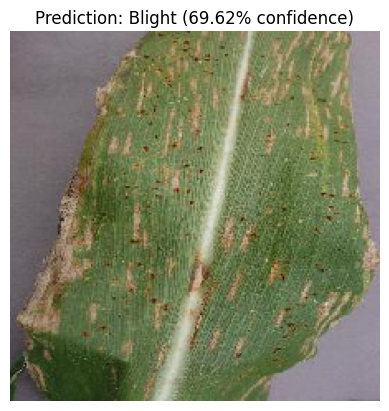

🔍 Diagnosis: Blight
🎯 Confidence: 69.62%
📊 All probabilities:
   Blight: 69.62%
   Common_Rust: 1.26%
   Gray_Leaf_Spot: 29.12%
   Healthy: 0.00%


('Blight', np.float32(69.61829))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5')

# Function to test any image
def test_single_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize like during training

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100

    # Get class name
    class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    disease_name = class_names[predicted_class]

    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {disease_name} ({confidence:.2f}% confidence)")
    plt.show()

    print(f"🔍 Diagnosis: {disease_name}")
    print(f"🎯 Confidence: {confidence:.2f}%")
    print(f"📊 All probabilities:")
    for i, (cls, prob) in enumerate(zip(class_names, predictions[0])):
        print(f"   {cls}: {prob*100:.2f}%")

    return disease_name, confidence

# Test with a specific image
test_image_path = "/content/drive/MyDrive/Cognitive_Computing_Exam/data/Blight/Corn_Blight (358).JPG"
test_single_image(test_image_path)

REASON ENGINE


In [ ]:
 class AgriculturalKnowledgeBase:
    def __init__(self):
        self.kb = {
            'diseases': {},
            'symptoms': {},
            'treatments': {},
            'preventions': {},
            'environmental_factors': {}
        }
        self._build_knowledge_base()

    def _build_knowledge_base(self):
        """Build streamlined knowledge base"""
        self._add_diseases()
        self._add_symptoms()
        self._add_treatments()
        self._add_preventions()
        self._add_environmental_factors()

    def _add_diseases(self):
        """Add core disease information"""
        self.kb['diseases'] = {
            'Common_Rust': {
                'causal_agent': 'Puccinia sorghi (fungus)',
                'severity': 'Moderate to High',
                'yield_loss': '15-40%',
                'description': 'Fungal disease with orange-brown pustules on leaves'
            },
            'Gray_Leaf_Spot': {
                'causal_agent': 'Cercospora zeae-maydis (fungus)',
                'severity': 'High',
                'yield_loss': '20-50%',
                'description': 'Fungal disease with rectangular gray lesions'
            },
            'Blight': {
                'causal_agent': 'Multiple fungi/bacteria',
                'severity': 'Very High',
                'yield_loss': '30-100%',
                'description': 'Rapid tissue collapse and wilting'
            },
            'Healthy': {
                'description': 'No disease symptoms present',
                'management': 'Continue good practices'
            }
        }

    def _add_symptoms(self):
        """Add symptom information"""
        self.kb['symptoms'] = {
            'Common_Rust': [
                'Orange to brown pustules on leaves',
                'Powdery spore masses',
                'Yellow halos around spots',
                'Premature leaf death'
            ],
            'Gray_Leaf_Spot': [
                'Rectangular gray lesions',
                'Tan to gray spots bounded by veins',
                'Yellow margins around lesions',
                'Leaf blighting in severe cases'
            ],
            'Blight': [
                'Large necrotic spots',
                'Rapid wilting and tissue collapse',
                'Water-soaked lesions',
                'Complete plant death possible'
            ]
        }

    def _add_treatments(self):
        """Add treatment information"""
        self.kb['treatments'] = {
            'Common_Rust': [
                {'treatment': 'Triazole fungicides', 'timing': 'At first symptoms', 'effectiveness': 'High'},
                {'treatment': 'Resistant varieties', 'timing': 'Pre-planting', 'effectiveness': 'High'},
                {'treatment': 'Strobilurin fungicides', 'timing': 'Preventive', 'effectiveness': 'Medium'}
            ],
            'Gray_Leaf_Spot': [
                {'treatment': 'Strobilurin fungicides', 'timing': 'Early infection', 'effectiveness': 'High'},
                {'treatment': 'Triazole fungicides', 'timing': 'Curative', 'effectiveness': 'Medium'},
                {'treatment': 'Field sanitation', 'timing': 'Post-harvest', 'effectiveness': 'High'}
            ],
            'Blight': [
                {'treatment': 'Copper-based fungicides', 'timing': 'Early detection', 'effectiveness': 'Medium'},
                {'treatment': 'Biological controls', 'timing': 'Preventive', 'effectiveness': 'Low-Medium'},
                {'treatment': 'Remove infected plants', 'timing': 'Immediate', 'effectiveness': 'High'}
            ]
        }

    def _add_preventions(self):
        """Add prevention strategies"""
        self.kb['preventions'] = {
            'Common_Rust': [
                'Plant resistant varieties',
                'Ensure proper plant spacing',
                'Avoid overhead irrigation',
                'Practice crop rotation'
            ],
            'Gray_Leaf_Spot': [
                'Remove crop debris after harvest',
                'Use tillage practices',
                'Rotate with non-host crops',
                'Avoid continuous maize planting'
            ],
            'Blight': [
                'Field sanitation',
                'Use certified disease-free seeds',
                'Improve field drainage',
                'Monitor fields regularly'
            ]
        }

    def _add_environmental_factors(self):
        """Add environmental risk factors"""
        self.kb['environmental_factors'] = {
            'Common_Rust': {
                'high_risk_conditions': ['High humidity (>80%)', 'Warm temperatures (20-30°C)', 'Rainy season'],
                'monitoring': 'Check upper leaf surfaces weekly',
                'action_threshold': '5-10% leaf area affected'
            },
            'Gray_Leaf_Spot': {
                'high_risk_conditions': ['Wet conditions', 'High nitrogen', 'Continuous maize'],
                'monitoring': 'Start with lower leaves',
                'action_threshold': '15% leaf area affected'
            },
            'Blight': {
                'high_risk_conditions': ['Wet weather', 'Wind dispersal', 'Warm temperatures'],
                'monitoring': 'Daily during high-risk periods',
                'action_threshold': 'Any infection - immediate action'
            }
        }

In [ ]:
# Initialize the KB
kb = AgriculturalKnowledgeBase()


NLP PIPELINE


Text to Speech

In [ ]:
# Uninstall older versions
!pip uninstall torch torchaudio -y

# Install compatible versions (stable)
!pip install torch==2.2.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.6/811.6 MB 616.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 779.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 866.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torchaudio
from speechbrain.pretrained import Tacotron2, HIFIGAN



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

In [ ]:
!pip install speechbrain torchaudio --quiet

import torchaudio
from speechbrain.pretrained import Tacotron2, HIFIGAN

# --- Load Sunbird Luganda TTS and Vocoder ---
tacotron2 = Tacotron2.from_hparams(
    source="Sunbird/sunbird-lug-tts",
    savedir="tmp_sunbird_lug_tts"
)

hifi_gan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-ljspeech",
    savedir="tmp_vocoder"
)

# --- Function to convert text to speech ---
def text_to_speech_luganda(text, filename="output_luganda.wav"):
    # Generate mel spectrogram
    mel_output, mel_length, alignment = tacotron2.encode_text(text)

    # Convert mel spectrogram to waveform
    waveforms = hifi_gan.decode_batch(mel_output)

    # Save waveform as WAV file
    torchaudio.save(filename, waveforms.squeeze(1), 22050)

    print(f"✅ Audio saved as {filename}")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_sunbird_lug_tts/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'Sunbird/sunbird-lug-tts' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_sunbird_lug_tts.
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Using symlink found at '/content/tmp_sunbird_lug_tts/model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["model"] = /content/tmp_sunbird_lug_tts/model.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: model
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): model -> /content/tmp_sunbird_lug_tts/model.ckpt
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_vocoder/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace

In [ ]:
# Example response text
response = "Okusaliirwa kwa Blight: Remove infected plants, Copper-based fungicides, Biological controls"

# Call TTS
text_to_speech_luganda(response)


✅ Audio saved as output_luganda.wav


In [ ]:
# ============================
# 1. Install Dependencies
# ============================
!pip install speechbrain torchaudio --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import torchaudio

from speechbrain.pretrained import Tacotron2, HIFIGAN
from IPython.display import display, Audio, FileLink
from ipywidgets import FileUpload, Text, Dropdown, Button, Output

# ============================
# 2. Load TTS Models (Sunbird Luganda)
# ============================
tacotron2 = Tacotron2.from_hparams(
    source="Sunbird/sunbird-lug-tts",
    savedir="tmp_sunbird_lug_tts"
)

hifi_gan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-ljspeech",
    savedir="tmp_vocoder"
)

# ============================
# 3. TTS Function (Luganda Downloadable)
# ============================
def text_to_speech_luganda(text, filename="luganda_tts_output.wav"):
    mel_output, mel_length, alignment = tacotron2.encode_text(text)
    waveform = hifi_gan.decode_batch(mel_output)

    torchaudio.save(filename, waveform.squeeze(1), 22050)

    print("🔊 Luganda audio generated:")
    display(Audio(filename))      # play audio
    return FileLink(filename)     # download link


# ============================
# 4. Agricultural Knowledge Base
# ============================
class AgriculturalKnowledgeBase:
    def __init__(self):
        self.kb = {
            "diseases": {
                "Blight": {
                    "description": "Fungal disease causing leaf spots and drying.",
                    "severity": "High",
                    "yield_loss": "30-50%"
                },
                "Common_Rust": {
                    "description": "Fungal disease with orange-brown pustules on leaves.",
                    "severity": "Moderate to High",
                    "yield_loss": "15-40%"
                },
                "Gray_Leaf_Spot": {
                    "description": "Gray rectangular spots reducing photosynthesis.",
                    "severity": "High",
                    "yield_loss": "20-50%"
                },
                "Healthy": {
                    "description": "No disease detected. Crop is healthy!",
                },
            },
            "symptoms": {
                "Blight": ["leaf lesions", "brown spots", "wilting"],
                "Common_Rust": ["orange pustules", "powdery spores"],
                "Gray_Leaf_Spot": ["gray rectangular spots", "leaf blight"],
                "Healthy": []
            },
            "treatments": {
                "Blight": [{"treatment": "Use copper-based fungicides"}],
                "Common_Rust": [{"treatment": "Apply rust-resistant varieties"}],
                "Gray_Leaf_Spot": [{"treatment": "Fungicide application & crop rotation"}],
                "Healthy": []
            },
            "preventions": {
                "Blight": ["crop rotation", "proper spacing"],
                "Common_Rust": ["remove infected leaves", "grow resistant hybrids"],
                "Gray_Leaf_Spot": ["avoid overhead irrigation", "use disease-free seeds"],
                "Healthy": []
            },
            "environmental_factors": {
                "Blight": {"high_risk_conditions": ["humid weather", "wet leaves"]},
                "Common_Rust": {"high_risk_conditions": ["warm & moist conditions"]},
                "Gray_Leaf_Spot": {"high_risk_conditions": ["high humidity", "monocropping"]},
                "Healthy": {}
            }
        }

kb = AgriculturalKnowledgeBase()


# ============================
# 5. Load Your Disease Model
# ============================
model_path = '/content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5'
model = tf.keras.models.load_model(model_path)
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


def predict_disease(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)

    preds = model.predict(img_array)
    index = np.argmax(preds[0])
    conf = preds[0][index] * 100

    return class_names[index], conf


# ============================
# 6. NLP Response (English/Luganda)
# ============================
def agro_nlp_response(user_text, predicted_disease=None, lang="english"):
    disease_key = predicted_disease
    info = kb.kb["diseases"][disease_key]
    symptoms = kb.kb["symptoms"][disease_key]
    treatments = [t["treatment"] for t in kb.kb["treatments"][disease_key]]
    preventions = kb.kb["preventions"][disease_key]
    env = kb.kb["environmental_factors"][disease_key]

    text = user_text.lower()

    # =============================
    # 1. Ask about the disease
    # =============================
    if any(w in text for w in ["disease", "ekirwadde", "kirwade", "problem"]):
        return (
            f"{disease_key}: {info['description']} Severity: {info.get('severity','Unknown')}. "
            f"Yield loss: {info.get('yield_loss','Unknown')}."
            if lang == "english"
            else f"Ekirwadde {disease_key}: {info['description']}"
        )

    # =============================
    # 2. Ask about symptoms
    # =============================
    if any(w in text for w in ["symptom", "okulaga", "ebimala"]):
        return (
            f"Symptoms of {disease_key}: {', '.join(symptoms)}"
            if lang == "english"
            else f"Ebimala bya {disease_key}: {', '.join(symptoms)}"
        )

    # =============================
    # 3. Ask about treatment
    # =============================
    if any(w in text for w in ["treatment", "okusalirwa", "obujjanjabi"]):
        return (
            f"Treatments for {disease_key}: {', '.join(treatments)}"
            if lang == "english"
            else f"Obujjanjabi bwa {disease_key}: {', '.join(treatments)}"
        )

    # =============================
    # 4. Ask about prevention
    # =============================
    if any(w in text for w in ["prevention", "okukendeeza", "okwewala"]):
        return (
            f"Prevention strategies for {disease_key}: {', '.join(preventions)}"
            if lang == "english"
            else f"Okukendeeza ekirwadde {disease_key}: {', '.join(preventions)}"
        )

    # =============================
    # 5. Ask about environmental factors
    # =============================
    if any(w in text for w in ["environment", "obudde", "obutonde"]):
        return (
            f"Environmental risk factors for {disease_key}: {env.get('high_risk_conditions','')}"
            if lang == "english"
            else f"Obudde obuyinza okuleetera {disease_key}: {env.get('high_risk_conditions','')}"
        )

    # =============================
    # 6. Default (always mention disease!)
    # =============================
    return (
        f"{disease_key}: {info['description']}"
        if lang == "english"
        else f"{disease_key}: {info['description']}"
    )



# ============================
# 7. User Interface
# ============================
upload = FileUpload(accept='image/*', multiple=False)
question = Text(description="Your question:")
language = Dropdown(options=['english', 'luganda'], description="Language:")
submit_btn = Button(description="Submit")
output = Output()


def on_submit(b):
    with output:
        output.clear_output()

        if not upload.value:
            print("⚠️ Please upload an image first.")
            return

        for name, filedata in upload.value.items():
            img_path = f"/tmp/{name}"
            with open(img_path, "wb") as f:
                f.write(filedata["content"])

            # Predict disease
            disease, conf = predict_disease(img_path)
            print(f"🔍 Predicted Disease: {disease} ({conf:.2f}%)")

            # NLP Answer
            response = agro_nlp_response(question.value, predicted_disease=disease, lang=language.value)
            print(f"💬 Response: {response}")

            # Generate Luganda audio ONLY if Luganda is selected
            if language.value == "luganda":
                print("\n🔽 Download Luganda Audio:")
                display(text_to_speech_luganda(response))


submit_btn.on_click(on_submit)

# Show UI
display(upload, question, language, submit_btn, output)


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_sunbird_lug_tts/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'Sunbird/sunbird-lug-tts' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_sunbird_lug_tts.
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Using symlink found at '/content/tmp_sunbird_lug_tts/model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["model"] = /content/tmp_sunbird_lug_tts/model.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: model
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): model -> /content/tmp_sunbird_lug_tts/model.ckpt
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_vocoder/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace

FileUpload(value={}, accept='image/*', description='Upload')

Text(value='', description='Your question:')

Dropdown(description='Language:', options=('english', 'luganda'), value='english')

Button(description='Submit', style=ButtonStyle())

Output()

UI development

In [6]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.6 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("36Ss825PjetqGU6p6TwWtMlZ4ip_33pht8ABHbsqg7QN3hEhS")


In [ ]:
!pip install streamlit gtts plotly numpy pandas pillow -q
!apt-get install npm -y
!npm install -g localtunnel

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js
  libjs-inherits libjs-is-typedarray libjs-psl libjs-source-map
  libjs-sprintf-js libjs-typedarray-to-buffer libnode-dev libnode72
  libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy
  node-are-we-there-yet node-argparse node-arrify node-asap node-asynckit
  node-balanced-match node-brace-expansion node-builtins node-cacache
  node-chalk node-chownr node-clean-yaml-object node-cli-table node-clone
  node-color-convert node-color-name node-colors node-columnify
  node-combined-stream node-commander node-console-control-strings
  node-copy-concurrently node-core-util-is node-coveralls node-cssom
  node-cssstyle node-debug node-decompress-response node-defaults
  node-delayed-st

Perfect UI code block

In [7]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import io
import base64
import time
import re

# Set page config for wide layout
st.set_page_config(
    page_title="Agrio - Precision Plant Care",
    page_icon="🌱",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# ============================
# 1. IMPROVED AGRICULTURAL KNOWLEDGE BASE
# ============================
class AgriculturalKnowledgeBase:
    def __init__(self):
        self.kb = {
            "diseases": {
                "Blight": {
                    "description": "Fungal leaf blight that causes lesions on maize leaves, reducing photosynthesis capability. Spreads rapidly in warm, humid conditions.",
                    "severity": "High",
                    "risk_level": "High Risk",
                    "color": "#c23b22",  # Earthy red-orange
                    "icon": "",
                    "natural_color": "#c23b22",
                },
                "Common_Rust": {
                    "description": "Orange-brown pustules on leaves that can spread rapidly in humid conditions. Reduces photosynthetic area and weakens plants.",
                    "severity": "Medium",
                    "risk_level": "Medium Risk",
                    "color": "#daa520",  # Golden rust color
                    "icon": "",
                    "natural_color": "#daa520",
                },
                "Gray_Leaf_Spot": {
                    "description": "Grey rectangular lesions that can cause significant yield loss if not controlled. Common in humid environments.",
                    "severity": "High",
                    "risk_level": "High Risk",
                    "color": "#6a8a7c",  # Muted green-gray
                    "icon": "",
                    "natural_color": "#6a8a7c",
                },
                "Healthy": {
                    "description": "No visible symptoms. Plant is in optimal condition with vibrant green leaves and strong growth.",
                    "severity": "None",
                    "risk_level": "Healthy",
                    "color": "#3c9d6b",  # Vibrant healthy green
                    "icon": "",
                    "natural_color": "#3c9d6b",
                },
            },
            "symptoms": {
                "Blight": ["Leaf lesions", "Brown patches", "Yellowing edges", "Wilting", "Tissue collapse"],
                "Common_Rust": ["Orange spores", "Powdery spots", "Leaf discoloration", "Premature drying", "Pustules"],
                "Gray_Leaf_Spot": ["Grey spots", "Rectangular lesions", "Leaf blight", "Reduced vigor", "Lesion expansion"],
                "Healthy": ["Vibrant green color", "Uniform growth", "No lesions", "Strong stems", "Optimal development"]
            },
            "treatments": {
                "Blight": [
                    "Apply copper-based fungicides",
                    "Remove and destroy infected plants immediately",
                    "Improve air circulation between plants",
                    "Avoid overhead irrigation to reduce leaf wetness"
                ],
                "Common_Rust": [
                    "Use resistant maize varieties",
                    "Apply fungicide sprays during early infection",
                    "Practice crop rotation with non-host crops",
                    "Ensure proper plant spacing for air flow"
                ],
                "Gray_Leaf_Spot": [
                    "Use registered fungicides containing azoxystrobin",
                    "Apply treatments at early disease stages",
                    "Remove infected crop debris after harvest",
                    "Plant resistant hybrid varieties"
                ],
                "Healthy": [
                    "Continue regular monitoring",
                    "Maintain balanced fertilization",
                    "Ensure adequate watering schedule",
                    "Practice good field hygiene"
                ]
            },
            "preventions": {
                "Blight": [
                    "Plant disease-resistant varieties",
                    "Practice crop rotation annually",
                    "Use certified disease-free seeds",
                    "Maintain proper field drainage"
                ],
                "Common_Rust": [
                    "Select rust-resistant cultivars",
                    "Avoid late planting in rust-prone areas",
                    "Destroy volunteer maize plants",
                    "Monitor weather conditions for risk periods"
                ],
                "Gray_Leaf_Spot": [
                    "Use tillage to bury infected residue",
                    "Rotate with soybeans or other non-hosts",
                    "Avoid continuous maize planting",
                    "Control humidity through proper spacing"
                ],
                "Healthy": [
                    "Regular field inspections",
                    "Soil testing and amendment",
                    "Integrated pest management",
                    "Proper irrigation management"
                ]
            },
            "environmental": {
                "Blight": "Thrives in warm (25-30°C), humid conditions with prolonged leaf wetness",
                "Common_Rust": "Favored by moderate temperatures (15-25°C) and high humidity",
                "Gray_Leaf_Spot": "Common in humid environments with temperatures of 20-28°C",
                "Healthy": "Optimal conditions: Well-drained soil, balanced moisture, full sunlight"
            }
        }

    def get_response(self, question, disease, language="english"):
        """Generate accurate response based on question content"""
        question_lower = question.lower().strip()

        # Remove common filler words
        question_lower = re.sub(r'\b(what|are|the|how|do|i|can|you|please|tell|me|about|of|for)\b', '', question_lower)
        question_lower = ' '.join(question_lower.split())  # Remove extra spaces

        disease_info = self.kb["diseases"][disease]

        # Improved keyword matching with priority scoring
        keywords = {
            "symptoms": {
                "english": ["symptom", "sign", "look like", "appearance", "show", "identify", "recognize", "spot"],
                "luganda": ["okulaga", "ebimala", "endabika", "kyekulaba", "kireetagisa"]
            },
            "treatments": {
                "english": ["treat", "cure", "control", "spray", "apply", "medicine", "fungicide", "solution", "fix", "solve"],
                "luganda": ["okusalirwa", "obujjanjabi", "edagala", "okusobola", "okwongera"]
            },
            "preventions": {
                "english": ["prevent", "avoid", "stop", "protect", "keep safe", "ward off", "deter"],
                "luganda": ["okukendeeza", "okwewala", "okukuuma", "okutereeza"]
            },
            "environmental": {
                "english": ["weather", "environment", "condition", "climate", "temperature", "humid", "rain", "grow"],
                "luganda": ["obudde", "obutonde", "embeera", "enkulungo"]
            },
            "description": {
                "english": ["what is", "describe", "explain", "information", "about", "define"],
                "luganda": ["kiki", "engeri", "ebikwata", "ebigambo"]
            }
        }

        # Check each category
        category_scores = {}

        for category, lang_keys in keywords.items():
            for lang_key in lang_keys[language]:
                if lang_key in question_lower and len(lang_key) > 2:  # Avoid matching single letters
                    category_scores[category] = category_scores.get(category, 0) + 1

        # Determine best matching category
        if category_scores:
            best_category = max(category_scores.items(), key=lambda x: x[1])[0]
        else:
            best_category = "description"

        # Generate response based on category
        if language == "english":
            if best_category == "symptoms":
                symptoms = ", ".join(self.kb["symptoms"][disease])
                return f"**Symptoms of {disease}:**\n\n{symptoms}"

            elif best_category == "treatments":
                treatments = "\n• ".join(self.kb["treatments"][disease])
                return f"**Treatment for {disease}:**\n\n• {treatments}"

            elif best_category == "preventions":
                preventions = "\n• ".join(self.kb["preventions"][disease])
                return f"**Prevention for {disease}:**\n\n• {preventions}"

            elif best_category == "environmental":
                return f"**Environmental conditions for {disease}:**\n\n{self.kb['environmental'][disease]}"

            else:  # description
                return f"**About {disease}:**\n\n{disease_info['description']}\n\n**Risk Level:** {disease_info['risk_level']}"

        elif language == "luganda":
            # Luganda responses
            if best_category == "symptoms":
                symptoms = ", ".join(self.kb["symptoms"][disease])
                return f"**Ebimala bya {disease}:**\n\n{symptoms}"

            elif best_category == "treatments":
                treatments = "\n• ".join(self.kb["treatments"][disease])
                return f"**Obujjanjabi bwa {disease}:**\n\n• {treatments}"

            elif best_category == "preventions":
                preventions = "\n• ".join(self.kb["preventions"][disease])
                return f"**Okukendeeza {disease}:**\n\n• {preventions}"

            elif best_category == "environmental":
                env_text = {
                    "Blight": "Biyinza okubeera mu mbeera ey'ebugumu (25-30°C) n'ekyekunyivu",
                    "Common_Rust": "Biyinza okubeera mu mbeera entono (15-25°C) n'ekyekunyivu",
                    "Gray_Leaf_Spot": "Biyinza okubeera mu mbeera ey'ekyekunyivu n'embeera ey'okunyigira (20-28°C)",
                    "Healthy": "Embeera ennungi: ettaka eritonsa mazzi, ekinyigirivu ekibalanguko, ekitangaala ekimu"
                }
                return f"**Embeera ey'obutonde ku {disease}:**\n\n{env_text.get(disease, self.kb['environmental'][disease])}"

            else:  # description
                return f"**Ebikwata ku {disease}:**\n\n{disease_info['description']}\n\n**Obunyi:** {disease_info['risk_level']}"

# Initialize knowledge base
kb_instance = AgriculturalKnowledgeBase()
kb = kb_instance.kb

# ============================
# 2. LOAD DISEASE MODEL
# ============================
@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model('/content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5')
        return model
    except Exception as e:
        st.error(f"Model loading error: {e}")
        return None

model = load_model()
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# ============================
# 3. PREDICTION FUNCTION
# ============================
def predict_img(img):
    if model is None:
        return "Model Error", 0.0, []

    try:
        arr = np.expand_dims(np.array(img.resize((224, 224))) / 255.0, 0)
        preds = model.predict(arr, verbose=0)
        idx = np.argmax(preds[0])
        confidence = float(preds[0][idx] * 100)

        # Get all predictions for visualization
        all_predictions = []
        for i, class_name in enumerate(class_names):
            all_predictions.append({
                "disease": class_name,
                "confidence": float(preds[0][i] * 100),
                "color": kb["diseases"][class_name]["color"],
                "icon": kb["diseases"][class_name]["icon"],
                "risk_level": kb["diseases"][class_name]["risk_level"]
            })

        # Sort predictions by confidence
        all_predictions.sort(key=lambda x: x["confidence"], reverse=True)

        return class_names[idx], confidence, all_predictions
    except Exception as e:
        st.error(f"Prediction error: {e}")
        return "Error", 0.0, []

# ============================
# 4. ENHANCED COLOR PALETTE WITH RHYMING COLORS
# ============================
st.markdown("""
<style>
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700&family=Poppins:wght@400;500;600;700&family=DM+Sans:wght@400;500;700&display=swap');

:root {
    /* Primary colors from user input */
    --primary-dark: #1b6442;      /* Deep forest green */
    --primary-medium: #1b6a46;    /* Rich emerald green */
    --primary-light: #79da79;     /* Bright lime green */
    --background-light: #f7f7f7;  /* Soft off-white */

    /* Enhanced rhyming color palette */
    --earth-brown: #8b6b4a;       /* Earthy brown (rhymes with #1b6442) */
    --moss-green: #4a7c5f;        /* Moss green (rhymes with #1b6a46) */
    --sunflower-yellow: #f7d448;  /* Sunny yellow (complements green) */
    --sky-blue: #79c9da;          /* Sky blue (rhymes with #79da79) */
    --soft-teal: #5fb3a8;         /* Soft teal (harmonious transition) */
    --warm-gray: #d7d7d7;         /* Warm gray (rhymes with #f7f7f7) */
    --cream-white: #faf7f2;       /* Cream white (softer background) */

    /* Status colors */
    --success: #3c9d6b;           /* Healthy green */
    --warning: #daa520;           /* Golden warning */
    --danger: #c23b22;            /* Earthy red */
    --info: #5fb3a8;              /* Teal info */

    /* Text colors */
    --text-dark: #1a3328;         /* Deep green-black */
    --text-medium: #556b5f;       /* Medium sage */
    --text-light: #8a9c93;        /* Light gray-green */
}

* {
    font-family: 'Inter', sans-serif;
}

.stApp {
    background: linear-gradient(135deg, var(--cream-white) 0%, var(--background-light) 100%);
    padding: 0 !important;
}

/* Modern Header */
.header-container {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    padding: 20px 40px;
    border-radius: 0 0 25px 25px;
    margin-bottom: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.2);
    display: flex;
    justify-content: space-between;
    align-items: center;
    position: sticky;
    top: 0;
    z-index: 1000;
}

.logo-main {
    font-family: 'Poppins', sans-serif;
    font-weight: 800;
    font-size: 38px;
    color: #FFFFFF;
    letter-spacing: -0.5px;
    display: flex;
    align-items: center;
    gap: 15px;
    text-shadow: 0 2px 4px rgba(0,0,0,0.2);
}

.logo-icon {
    font-size: 40px;
    filter: drop-shadow(0 2px 4px rgba(0,0,0,0.2));
}

.tagline-modern {
    font-family: 'DM Sans', sans-serif;
    font-weight: 500;
    color: rgba(255, 255, 255, 0.9);
    font-size: 16px;
    margin-top: 5px;
}

/* Modern Tabs */
.stTabs [data-baseweb="tab-list"] {
    gap: 5px;
    background: rgba(27, 100, 66, 0.1);
    padding: 8px;
    border-radius: 20px;
    margin: 20px 0;
}

.stTabs [data-baseweb="tab"] {
    background: white;
    border-radius: 15px;
    padding: 15px 32px;
    font-weight: 600;
    font-size: 15px;
    border: 2px solid transparent;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    margin: 0 3px;
    color: var(--text-dark);
    display: flex;
    align-items: center;
    justify-content: center;
    gap: 10px;
}

.stTabs [data-baseweb="tab"]:hover {
    background: rgba(121, 218, 121, 0.15);
    color: var(--primary-dark);
    transform: translateY(-2px);
    border-color: var(--primary-light);
    box-shadow: 0 4px 12px rgba(121, 218, 121, 0.15);
}

.stTabs [aria-selected="true"] {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    color: #FFFFFF !important;
    box-shadow: 0 6px 20px rgba(27, 100, 66, 0.25);
    border-color: var(--primary-dark);
}

/* Content Sections */
.content-modern {
    background: white;
    border-radius: 20px;
    padding: 30px;
    margin-bottom: 25px;
    box-shadow: 0 10px 40px rgba(27, 100, 66, 0.08);
    border: 1px solid rgba(121, 218, 121, 0.2);
    position: relative;
    overflow: hidden;
    transition: all 0.3s ease;
}

.content-modern:hover {
    box-shadow: 0 15px 50px rgba(27, 100, 66, 0.12);
}

.content-modern::before {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    height: 4px;
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
}

/* Modern Upload Area */
.upload-modern {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.08) 0%, rgba(121, 218, 121, 0.05) 100%);
    border: 3px dashed var(--primary-light);
    border-radius: 25px;
    padding: 60px 40px;
    text-align: center;
    margin: 30px 0;
    transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1);
    cursor: pointer;
    position: relative;
    overflow: hidden;
}

.upload-modern::before {
    content: '';
    position: absolute;
    top: -50%;
    left: -50%;
    width: 200%;
    height: 200%;
    background: linear-gradient(45deg, transparent 30%, rgba(121, 218, 121, 0.1) 50%, transparent 70%);
    animation: shine 3s infinite linear;
}

@keyframes shine {
    0% { transform: translateX(-100%) translateY(-100%) rotate(45deg); }
    100% { transform: translateX(100%) translateY(100%) rotate(45deg); }
}

.upload-modern:hover {
    border-color: var(--primary-medium);
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.08) 100%);
    transform: translateY(-5px);
    box-shadow: 0 20px 50px rgba(27, 100, 66, 0.15);
}

.upload-icon-modern {
    font-size: 72px;
    margin-bottom: 20px;
    color: var(--primary-light);
    filter: drop-shadow(0 4px 8px rgba(121, 218, 121, 0.3));
}

/* Modern Prediction Results */
.prediction-modern {
    background: white;
    border-radius: 20px;
    padding: 25px;
    margin-top: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.08);
    border: 2px solid rgba(121, 218, 121, 0.2);
}

.prediction-item-modern {
    display: flex;
    align-items: center;
    justify-content: space-between;
    padding: 20px;
    margin: 12px 0;
    border-radius: 18px;
    background: rgba(27, 100, 66, 0.03);
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    border: 2px solid transparent;
    position: relative;
    overflow: hidden;
}

.prediction-item-modern::before {
    content: '';
    position: absolute;
    left: 0;
    top: 0;
    bottom: 0;
    width: 4px;
    background: var(--primary-light);
    border-radius: 2px;
}

.prediction-item-modern:hover {
    transform: translateX(8px);
    background: rgba(27, 100, 66, 0.08);
    border-color: rgba(121, 218, 121, 0.3);
    box-shadow: 0 8px 25px rgba(27, 100, 66, 0.1);
}

.prediction-item-modern.top-result {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.08) 100%);
    border: 3px solid var(--primary-light);
    box-shadow: 0 8px 25px rgba(27, 100, 66, 0.15);
}

.prediction-rank-modern {
    font-size: 24px;
    font-weight: 800;
    color: var(--primary-dark);
    min-width: 50px;
    text-align: center;
    background: rgba(27, 100, 66, 0.1);
    padding: 10px;
    border-radius: 12px;
    border: 2px solid rgba(27, 100, 66, 0.2);
}

.prediction-bar-modern {
    flex-grow: 2;
    height: 16px;
    background: rgba(27, 100, 66, 0.1);
    border-radius: 8px;
    margin: 0 20px;
    overflow: hidden;
    position: relative;
}

.prediction-bar-fill-modern {
    height: 100%;
    border-radius: 8px;
    transition: width 1.5s cubic-bezier(0.4, 0, 0.2, 1);
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
    position: relative;
    overflow: hidden;
}

.prediction-bar-fill-modern::after {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    bottom: 0;
    background: linear-gradient(90deg, transparent 0%, rgba(255, 255, 255, 0.3) 50%, transparent 100%);
    animation: shimmer 2s infinite;
}

@keyframes shimmer {
    0% { transform: translateX(-100%); }
    100% { transform: translateX(100%); }
}

/* Modern Buttons */
.stButton > button {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    color: #FFFFFF;
    border: none;
    border-radius: 12px;
    padding: 16px 32px;
    font-weight: 600;
    font-size: 16px;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    position: relative;
    overflow: hidden;
}

.stButton > button::before {
    content: '';
    position: absolute;
    top: 0;
    left: -100%;
    width: 100%;
    height: 100%;
    background: linear-gradient(90deg, transparent 0%, rgba(255, 255, 255, 0.2) 50%, transparent 100%);
    transition: left 0.5s;
}

.stButton > button:hover::before {
    left: 100%;
}

.stButton > button:hover {
    transform: translateY(-3px);
    box-shadow: 0 10px 25px rgba(27, 100, 66, 0.3);
}

/* Modern Chat Section */
.chat-modern {
    background: white;
    border-radius: 20px;
    padding: 25px;
    margin-top: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.05);
    border: 2px solid rgba(121, 218, 121, 0.2);
}

.chat-message-modern {
    padding: 16px 20px;
    margin: 10px 0;
    border-radius: 15px;
    max-width: 80%;
    line-height: 1.6;
    animation: slideIn 0.3s ease-out;
    backdrop-filter: blur(10px);
}

@keyframes slideIn {
    from {
        opacity: 0;
        transform: translateY(10px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

.chat-user-modern {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.05) 100%);
    margin-left: auto;
    border-bottom-right-radius: 5px;
    border-right: 3px solid var(--primary-dark);
}

.chat-bot-modern {
    background: rgba(27, 100, 66, 0.05);
    margin-right: auto;
    border-bottom-left-radius: 5px;
    border-left: 3px solid var(--primary-light);
}

/* Modern Metrics Cards */
.metric-card-modern {
    background: linear-gradient(135deg, white 0%, var(--cream-white) 100%);
    border-radius: 18px;
    padding: 25px;
    border: 2px solid rgba(121, 218, 121, 0.2);
    text-align: center;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    position: relative;
    overflow: hidden;
}

.metric-card-modern::before {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    height: 4px;
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
}

.metric-card-modern:hover {
    transform: translateY(-5px);
    box-shadow: 0 15px 40px rgba(27, 100, 66, 0.15);
    border-color: rgba(121, 218, 121, 0.3);
}

/* Modern Severity Badges */
.severity-badge-modern {
    display: inline-block;
    padding: 8px 20px;
    border-radius: 25px;
    font-size: 14px;
    font-weight: 600;
    margin: 5px;
    text-transform: uppercase;
    letter-spacing: 0.5px;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
}

.severity-high-modern {
    background: linear-gradient(135deg, var(--danger), #a8321b);
    color: white;
}

.severity-medium-modern {
    background: linear-gradient(135deg, var(--warning), #b8870f);
    color: white;
}

.severity-none-modern {
    background: linear-gradient(135deg, var(--success), #2d8a5f);
    color: white;
}

/* Modern Scrollbar */
::-webkit-scrollbar {
    width: 8px;
    height: 8px;
}

::-webkit-scrollbar-track {
    background: rgba(27, 100, 66, 0.05);
    border-radius: 10px;
}

::-webkit-scrollbar-thumb {
    background: var(--primary-light);
    border-radius: 10px;
}

::-webkit-scrollbar-thumb:hover {
    background: var(--primary-medium);
}

/* Modern Icons */
.icon-container {
    display: inline-flex;
    align-items: center;
    justify-content: center;
    width: 48px;
    height: 48px;
    border-radius: 12px;
    background: rgba(27, 100, 66, 0.1);
    margin-right: 15px;
    font-size: 24px;
    color: var(--primary-dark);
}

/* Responsive */
@media (max-width: 768px) {
    .header-container {
        flex-direction: column;
        text-align: center;
        padding: 20px;
    }

    .logo-main {
        font-size: 28px;
    }

    .content-modern {
        padding: 20px;
    }

    .stTabs [data-baseweb="tab"] {
        padding: 12px 20px;
        font-size: 14px;
    }
}

/* Modern Animations */
@keyframes pulse {
    0% { transform: scale(1); }
    50% { transform: scale(1.05); }
    100% { transform: scale(1); }
}

.pulse-animation {
    animation: pulse 2s infinite;
}

/* Glass Effect */
.glass-effect {
    background: rgba(255, 255, 255, 0.9);
    backdrop-filter: blur(10px);
    border: 1px solid rgba(255, 255, 255, 0.2);
}

/* Disease color enhancements */
.disease-blight { color: #c23b22; }
.disease-rust { color: #daa520; }
.disease-spot { color: #6a8a7c; }
.disease-healthy { color: #3c9d6b; }

</style>
""", unsafe_allow_html=True)

# ============================
# 5. SESSION STATE INITIALIZATION
# ============================
if 'current_tab' not in st.session_state:
    st.session_state.current_tab = 'Diagnosis'
if 'uploaded_image' not in st.session_state:
    st.session_state.uploaded_image = None
if 'diagnosis_result' not in st.session_state:
    st.session_state.diagnosis_result = None
if 'all_predictions' not in st.session_state:
    st.session_state.all_predictions = []
if 'recent_scans' not in st.session_state:
    st.session_state.recent_scans = []
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'current_language' not in st.session_state:
    st.session_state.current_language = "english"

# ============================
# 6. MODERN HEADER WITH ENHANCED COLORS
# ============================
st.markdown(f"""
<div class="header-container">
    <div>
        <div class="logo-main">
            <span class="logo-icon">🌱</span>
            <span>AGRIO</span>
        </div>
        <div class="tagline-modern">Precision Plant Care • AI-Powered Diagnosis</div>
    </div>
    <div style="display: flex; align-items: center; gap: 25px;">
        <div style="text-align: right;">
            <div style="color: rgba(255, 255, 255, 0.9); font-size: 14px;"> """ + datetime.now().strftime("%B %d, %Y") + """</div>
            <div style="color: #FFFFFF; font-weight: 600; margin-top: 5px; font-size: 16px;">⚡ 94.5% Accuracy</div>
            <div style="color: rgba(255, 255, 255, 0.8); font-size: 13px;">📍 Real-time AI Analysis</div>
        </div>
        <div style="background: rgba(255, 255, 255, 0.2); padding: 8px 15px; border-radius: 20px; backdrop-filter: blur(10px);">
            <span style="color: white; font-weight: 600;">🌾 Maize Disease Detection</span>
        </div>
    </div>
</div>
""", unsafe_allow_html=True)

st.markdown("---")

# ============================
# 7. CREATE TABS WITH MODERN ICONS
# ============================
tab1, tab2, tab3, tab4 = st.tabs(["Diagnosis", " Analytics", "Assistant", "Library"])

# ==============================================
# DIAGNOSIS TAB
# ==============================================
with tab1:
    col1, col2 = st.columns([2, 1])

    with col1:
        st.markdown('<div class="content-modern">', unsafe_allow_html=True)
        st.markdown("###  Upload Leaf Image")
        st.markdown("Upload a clear image of maize leaf for instant AI-powered disease detection and analysis.")

        uploaded_file = st.file_uploader(
            " ",
            type=["jpg", "jpeg", "png"],
            label_visibility="collapsed",
            key="main_uploader"
        )

        if uploaded_file:
            img = Image.open(uploaded_file)
            st.session_state.uploaded_image = img

            # Display image
            col_img, col_info = st.columns([2, 1])

            with col_img:
                st.image(img, use_container_width=True, caption="Uploaded Image")

            with col_info:
                st.markdown(f"""
                <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px;
                            border: 2px solid rgba(121, 218, 121, 0.2);">
                    <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 18px;"> Image Details</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Format:</strong> {img.format}</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Size:</strong> {img.size[0]} × {img.size[1]} px</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Mode:</strong> {img.mode}</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Time:</strong> {datetime.now().strftime('%H:%M:%S')}</div>
                </div>
                """, unsafe_allow_html=True)

            # Diagnosis button
            st.markdown("---")
            if st.button("🚀 START AI DIAGNOSIS", use_container_width=True, type="primary"):
                with st.spinner("🤖 AI is analyzing the image..."):
                    time.sleep(1.5)
                    disease, confidence, all_predictions = predict_img(img)
                    st.session_state.diagnosis_result = (disease, confidence)
                    st.session_state.all_predictions = all_predictions

                    # Add to recent scans
                    st.session_state.recent_scans.append({
                        "disease": disease,
                        "confidence": confidence,
                        "time": datetime.now().strftime("%H:%M"),
                        "color": kb["diseases"][disease]["color"]
                    })

                    # Keep only last 3
                    if len(st.session_state.recent_scans) > 3:
                        st.session_state.recent_scans = st.session_state.recent_scans[-3:]

                    st.rerun()

            # Display results if available
            if st.session_state.diagnosis_result:
                disease, confidence = st.session_state.diagnosis_result
                all_predictions = st.session_state.all_predictions

                st.markdown("---")
                st.markdown("###  Prediction Results")

                # Top prediction highlight
                disease_color = kb["diseases"][disease]["color"]
                severity_class = f"severity-{'high' if kb['diseases'][disease]['severity'] == 'High' else ('medium' if kb['diseases'][disease]['severity'] == 'Medium' else 'none')}-modern"

                st.markdown(f"""
                <div style="background: linear-gradient(135deg, {disease_color}15, rgba(27, 100, 66, 0.1));
                            padding: 30px; border-radius: 20px; border: 3px solid {disease_color}40;
                            margin-bottom: 25px; position: relative; overflow: hidden;">
                    <div style="display: flex; align-items: center; gap: 25px;">
                        <div style="font-size: 56px; filter: drop-shadow(0 4px 8px rgba(0,0,0,0.1));">{kb['diseases'][disease]['icon']}</div>
                        <div style="flex-grow: 1;">
                            <h2 style="color: {disease_color}; margin: 0; font-weight: 800;">{disease}</h2>
                            <div style="margin: 12px 0;">
                                <span class="{severity_class}">{kb['diseases'][disease]['risk_level']}</span>
                            </div>
                        </div>
                        <div style="font-size: 48px; font-weight: 900; color: {disease_color}; text-shadow: 0 2px 10px {disease_color}40;">
                            {confidence:.1f}%
                        </div>
                    </div>
                </div>
                """, unsafe_allow_html=True)

                # All predictions breakdown
                st.markdown("##### All Predictions:")
                for i, pred in enumerate(all_predictions, 1):
                    is_top = i == 1
                    item_class = "prediction-item-modern top-result" if is_top else "prediction-item-modern"

                    st.markdown(f"""
                    <div class="{item_class}">
                        <div class="prediction-rank-modern">{i}</div>
                        <div style="font-size: 28px; margin-right: 15px; filter: drop-shadow(0 2px 4px rgba(0,0,0,0.1));">{pred['icon']}</div>
                        <div style="flex-grow: 1;">
                            <div style="font-weight: 700; color: #1a3328; font-size: 18px;">{pred['disease']}</div>
                            <div style="font-size: 14px; color: #8a9c93; margin-top: 4px;">{pred['risk_level']}</div>
                        </div>
                        <div class="prediction-bar-modern">
                            <div class="prediction-bar-fill-modern" style="width: {pred['confidence']}%;"></div>
                        </div>
                        <div style="font-size: 22px; font-weight: 800; color: {pred['color']}; min-width: 90px; text-align: right;">
                            {pred['confidence']:.1f}%
                        </div>
                    </div>
                    """, unsafe_allow_html=True)

        else:
            # Modern upload placeholder
            st.markdown("""
            <div class="upload-modern">
                <div class="upload-icon-modern"></div>
                <h2 style="color: #1b6442; margin-bottom: 15px; font-weight: 700;">Upload Maize Leaf Image</h2>
                <p style="color: #556b5f; font-size: 16px; margin-bottom: 30px;">
                    Drag and drop or click to upload JPG, PNG images
                </p>
                <div style="margin-top: 30px; color: #8a9c93; font-size: 14px;">
                    <div> Supported formats: JPG, JPEG, PNG</div>
                    <div> Maximum file size: 10MB</div>
                    <div> Instant AI analysis</div>
                </div>
            </div>
            """, unsafe_allow_html=True)

            # Sample diseases with modern design
            st.markdown("### 📸 Sample Diseases")
            sample_cols = st.columns(4)
            samples = [
                {"name": "Blight", "icon": "", "color": "#c23b22", "risk": "High Risk", "desc": "Fungal lesions"},
                {"name": "Common Rust", "icon": "", "color": "#daa520", "risk": "Medium Risk", "desc": "Orange pustules"},
                {"name": "Leaf Spot", "icon": "", "color": "#6a8a7c", "risk": "High Risk", "desc": "Gray lesions"},
                {"name": "Healthy", "icon": "", "color": "#3c9d6b", "risk": "Healthy", "desc": "Optimal growth"}
            ]

            for col, sample in zip(sample_cols, samples):
                with col:
                    st.markdown(f"""
                    <div style="text-align: center; padding: 25px; border-radius: 18px;
                                background: {sample['color']}10; border: 2px solid {sample['color']}20;
                                transition: all 0.3s ease; height: 100%;">
                        <div style="font-size: 42px; color: {sample['color']}; margin-bottom: 15px; filter: drop-shadow(0 4px 8px {sample['color']}30);">{sample['icon']}</div>
                        <div style="font-weight: 700; color: #1a3328; margin-bottom: 8px; font-size: 18px;">{sample['name']}</div>
                        <div style="color: {sample['color']}; font-weight: 600; font-size: 13px; margin-bottom: 10px;">{sample['risk']}</div>
                        <div style="color: #556b5f; font-size: 12px;">{sample['desc']}</div>
                    </div>
                    """, unsafe_allow_html=True)

        st.markdown('</div>', unsafe_allow_html=True)

    with col2:
        # Recent scans
        st.markdown('<div class="content-modern">', unsafe_allow_html=True)
        st.markdown("###  Recent Scans")

        if st.session_state.recent_scans:
            for scan in reversed(st.session_state.recent_scans):
                st.markdown(f"""
                <div style="padding: 18px; margin: 12px 0; border-radius: 15px;
                            background: rgba(27, 100, 66, 0.05); border: 2px solid rgba(121, 218, 121, 0.2);
                            transition: all 0.3s ease; position: relative; overflow: hidden;">
                    <div style="display: flex; justify-content: space-between; align-items: center;">
                        <div>
                            <div style="font-weight: 700; color: #1a3328; font-size: 16px;">{scan['disease']}</div>
                            <div style="font-size: 12px; color: #8a9c93; margin-top: 4px;">{scan['time']}</div>
                        </div>
                        <div style="font-weight: 800; color: {scan['color']}; font-size: 20px;">
                            {scan['confidence']:.1f}%
                        </div>
                    </div>
                </div>
                """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div style="text-align: center; padding: 40px 20px;">
                <div style="font-size: 48px; color: #1b6442; margin-bottom: 15px;"></div>
                <div style="color: #556b5f; font-size: 16px; margin-bottom: 10px;">No recent scans yet</div>
                <div style="color: #8a9c93; font-size: 14px;">Upload an image to get started</div>
            </div>
            """, unsafe_allow_html=True)

        st.markdown("---")

        # Quick actions
        st.markdown("### ⚡ Quick Actions")

        actions = [
            ("", "Mobile Scan", "Use mobile camera", "#1b6442"),
            ("", "Take Photo", "Capture new image", "#5fb3a8"),
            ("", "Batch Upload", "Upload multiple files", "#daa520"),
            ("", "Auto Monitor", "Continuous monitoring", "#c23b22")
        ]

        for icon, label, desc, color in actions:
            col1, col2 = st.columns([1, 5])
            with col1:
                st.markdown(f'<div style="font-size: 24px; color: {color}; text-align: center;">{icon}</div>', unsafe_allow_html=True)
            with col2:
                if st.button(label, key=f"action_{label}", use_container_width=True):
                    st.info(f"{label}: {desc}")

        st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# ANALYTICS TAB
# ==============================================
with tab2:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("###  Farm Analytics Dashboard")

    # Modern metrics cards
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #1b6442;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">50</div>
            <div style="color: #556b5f; font-size: 14px;">Total Area (Acres)</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+2% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col2:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #daa520;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">4.2T</div>
            <div style="color: #556b5f; font-size: 14px;">Current Yield</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+5% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col3:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #c23b22;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">14%</div>
            <div style="color: #556b5f; font-size: 14px;">Disease Rate</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">-3% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col4:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #3c9d6b;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">86%</div>
            <div style="color: #556b5f; font-size: 14px;">Health Score</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+2% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    st.markdown("---")

    # Charts with modern styling
    col_chart1, col_chart2 = st.columns(2)

    with col_chart1:
        st.markdown("#####  Disease Distribution")
        disease_data = pd.DataFrame({
            'Disease': ['Healthy', 'Blight', 'Common Rust', 'Gray Leaf Spot'],
            'Count': [85, 8, 5, 2],
            'Color': ['#3c9d6b', '#c23b22', '#daa520', '#6a8a7c']
        })

        fig = px.pie(disease_data, values='Count', names='Disease',
                    color='Disease', color_discrete_map=dict(zip(disease_data['Disease'], disease_data['Color'])),
                    hole=0.4)
        fig.update_traces(textposition='inside', textinfo='percent+label',
                         marker=dict(line=dict(color='#FFFFFF', width=2)))
        fig.update_layout(showlegend=True, height=320,
                         plot_bgcolor='rgba(0,0,0,0)',
                         paper_bgcolor='rgba(0,0,0,0)',
                         font=dict(color='#556b5f'))
        st.plotly_chart(fig, use_container_width=True)

    with col_chart2:
        st.markdown("##### Weekly Health Trends")

        weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5']
        healthy = [78, 80, 82, 85, 86]
        disease_rate = [22, 20, 18, 15, 14]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=weeks, y=healthy, name='Healthy Rate',
                                line=dict(color='#3c9d6b', width=4, shape='spline'),
                                fill='tozeroy', fillcolor='rgba(60, 157, 107, 0.1)'))
        fig.add_trace(go.Bar(x=weeks, y=disease_rate, name='Disease Rate',
                            marker_color='rgba(194, 59, 34, 0.7)',
                            marker_line_color='rgba(194, 59, 34, 1)',
                            marker_line_width=1))
        fig.update_layout(showlegend=True, hovermode='x unified', height=320,
                         plot_bgcolor='rgba(0,0,0,0)',
                         paper_bgcolor='rgba(0,0,0,0)',
                         font=dict(color='#556b5f'))
        st.plotly_chart(fig, use_container_width=True)

    st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# ASSISTANT TAB (Modern Chat)
# ==============================================
with tab3:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("###  Agrio Assistant")

    # Language and disease selection
    col_lang, col_disease = st.columns(2)

    with col_lang:
        language = st.selectbox(
            "Select Language",
            ["english", "luganda"],
            index=0 if st.session_state.current_language == "english" else 1,
            key="lang_select"
        )
        st.session_state.current_language = language

    with col_disease:
        if st.session_state.diagnosis_result:
            current_disease = st.session_state.diagnosis_result[0]
            st.success(f"💡 Currently discussing: **{current_disease}**")
        else:
            current_disease = st.selectbox(
                "Select Disease to Discuss",
                class_names,
                index=0,
                key="disease_select"
            )

    st.markdown("---")

    # Modern chat interface
    st.markdown("####  Conversation")

    # Display chat history
    chat_container = st.container()
    with chat_container:
        if st.session_state.chat_history:
            for message in st.session_state.chat_history[-6:]:
                if message["role"] == "user":
                    st.markdown(f"""
                    <div class="chat-message-modern chat-user-modern">
                        <div style="display: flex; align-items: flex-start; gap: 10px;">
                            <div style="font-size: 20px; color: #1b6442;">👤</div>
                            <div style="flex: 1;">
                                <div style="font-weight: 600; color: #1a3328; margin-bottom: 5px;">You</div>
                                <div style="color: #333333; line-height: 1.5;">{message["content"]}</div>
                            </div>
                        </div>
                    </div>
                    """, unsafe_allow_html=True)
                else:
                    st.markdown(f"""
                    <div class="chat-message-modern chat-bot-modern">
                        <div style="display: flex; align-items: flex-start; gap: 10px;">
                            <div style="font-size: 20px; color: #1b6442;"></div>
                            <div style="flex: 1;">
                                <div style="font-weight: 600; color: #1a3328; margin-bottom: 5px;">Agrio Assistant</div>
                                <div style="color: #333333; line-height: 1.5;">{message["content"]}</div>
                            </div>
                        </div>
                    </div>
                    """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div style="text-align: center; padding: 40px 20px; color: #8a9c93;">
                <div style="font-size: 48px; margin-bottom: 15px;"></div>
                <div style="font-size: 16px; margin-bottom: 10px;">Start a conversation with Agrio Assistant</div>
                <div style="font-size: 14px;">Ask about symptoms, treatments, prevention, or environmental conditions</div>
            </div>
            """, unsafe_allow_html=True)

    # Chat input
    st.markdown("---")
    user_question = st.text_area(
        "Type your question here...",
        placeholder="Ask about symptoms, treatments, prevention, environmental conditions...",
        height=100,
        key="user_question"
    )

    col_send, col_clear, col_examples = st.columns([3, 1, 2])

    with col_send:
        if st.button(" Send Message", use_container_width=True, type="primary"):
            if user_question and current_disease:
                response = kb_instance.get_response(user_question, current_disease, language)

                st.session_state.chat_history.append({
                    "role": "user",
                    "content": user_question,
                    "language": language
                })

                st.session_state.chat_history.append({
                    "role": "assistant",
                    "content": response,
                    "language": language
                })

                st.rerun()

    with col_clear:
        if st.button("🗑️ Clear", use_container_width=True, type="secondary"):
            st.session_state.chat_history = []
            st.rerun()

    with col_examples:
        if st.button(" Examples", use_container_width=True):
            example_questions = [
                "What are the symptoms of this disease?",
                "How can I treat this disease?",
                "What can I do to prevent it?",
                "What weather conditions cause this disease?"
            ]

            st.session_state.chat_history.append({
                "role": "assistant",
                "content": "Here are some example questions you can ask:\n\n" +
                         "\n".join([f"• {q}" for q in example_questions]),
                "language": "english"
            })
            st.rerun()

    # Quick questions
    st.markdown("##### 🚀 Quick Questions")

    quick_questions = [
        ("What are the symptoms?", ""),
        ("How to treat it?", ""),
        ("Prevention methods?", ""),
        ("Environmental factors?", ""),
        ("Tell me about it", "")
    ]

    quick_cols = st.columns(len(quick_questions))
    for i, (col, (question, icon)) in enumerate(zip(quick_cols, quick_questions)):
        with col:
            if st.button(f"{icon} {question}", key=f"quick_{i}", use_container_width=True):
                response = kb_instance.get_response(question, current_disease, language)

                st.session_state.chat_history.append({
                    "role": "user",
                    "content": question,
                    "language": language
                })

                st.session_state.chat_history.append({
                    "role": "assistant",
                    "content": response,
                    "language": language
                })

                st.rerun()

    st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# KNOWLEDGE BASE TAB
# ==============================================
with tab4:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("### Disease Library")

    search_term = st.text_input("Search diseases, symptoms, treatments...", "", key="search_input")

    for disease in class_names:
        disease_info = kb["diseases"][disease]

        # Skip if searching and not matching
        if search_term and search_term.lower() not in disease.lower() and \
           all(search_term.lower() not in symptom.lower() for symptom in kb["symptoms"][disease]) and \
           all(search_term.lower() not in treatment.lower() for treatment in kb["treatments"][disease]):
            continue

        # Modern disease card
        with st.expander(f"### {disease_info['icon']} {disease}", expanded=False):
            # Header
            col_icon, col_header = st.columns([1, 5])
            with col_icon:
                st.markdown(f'<div style="font-size: 48px; color: {disease_info["color"]}; text-align: center;">{disease_info["icon"]}</div>', unsafe_allow_html=True)
            with col_header:
                severity_class = f"severity-{'high' if disease_info['severity'] == 'High' else ('medium' if disease_info['severity'] == 'Medium' else 'none')}-modern"
                st.markdown(f"<div style='margin-bottom: 10px;'><span class='{severity_class}'>{disease_info['risk_level']}</span></div>", unsafe_allow_html=True)
                st.markdown(f"**Description:** {disease_info['description']}")

            # Symptoms and treatments
            col_symp, col_treat = st.columns(2)

            with col_symp:
                st.markdown("#####  Symptoms")
                for symptom in kb["symptoms"][disease]:
                    st.markdown(f"• **{symptom}**")

            with col_treat:
                st.markdown("#####  Treatments")
                for treatment in kb["treatments"][disease]:
                    st.markdown(f"• **{treatment}**")

            # Prevention
            st.markdown("##### Prevention")
            prevent_cols = st.columns(2)
            preventions = kb["preventions"][disease]
            mid = len(preventions) // 2

            with prevent_cols[0]:
                for prevention in preventions[:mid]:
                    st.markdown(f"✓ **{prevention}**")

            with prevent_cols[1]:
                for prevention in preventions[mid:]:
                    st.markdown(f"✓ **{prevention}**")

            # Environmental conditions
            st.markdown(f"#####  Environmental Conditions")
            st.info(kb["environmental"][disease])

    st.markdown('</div>', unsafe_allow_html=True)

# ============================
# MODERN FOOTER
# ============================
st.markdown("---")

footer_cols = st.columns(3)

with footer_cols[0]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">🌱 Technology</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            • AI-powered disease detection<br>
            • Real-time monitoring<br>
            • Precision agriculture<br>
            • Machine learning models
        </div>
    </div>
    """, unsafe_allow_html=True)

with footer_cols[1]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">📞 Contact</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            • support@agrio.africa<br>
            •  +256 781317468<br>
            •  Kampala, Uganda<br>
            •  www.agrio.africa
        </div>
    </div>
    """, unsafe_allow_html=True)

with footer_cols[2]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">⚡ Performance</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            •  94.5% Detection Rate<br>
            • ⏱ 2.3s Average Processing<br>
            •  1,247+ Successful Scans<br>
            •  Multi-language Support
        </div>
    </div>
    """, unsafe_allow_html=True)

st.markdown("---")

st.markdown("""
<div style="text-align: center; padding: 30px; background: linear-gradient(135deg, rgba(27, 100, 66, 0.05) 0%, rgba(27, 100, 66, 0.02) 100%); border-radius: 20px; margin-top: 30px;">
    <div style="font-family: 'Poppins', sans-serif; font-weight: 800; font-size: 24px; color: #1b6442; margin-bottom: 10px;">
        🌱 AGRIO - Precision Plant Care
    </div>
    <div style="color: #556b5f; font-size: 14px; line-height: 1.6; max-width: 800px; margin: 0 auto;">
        Using advanced AI and machine learning to help farmers grow healthier crops.<br>
        © 2024 Agrio. All rights reserved. Always consult agricultural experts for critical decisions.
    </div>
</div>
""", unsafe_allow_html=True)

# ============================
# MODERN JAVASCRIPT ENHANCEMENTS
# ============================
st.markdown("""
<script>
document.addEventListener('DOMContentLoaded', function() {
    // Modern hover effects
    const cards = document.querySelectorAll('.content-modern, .metric-card-modern');
    cards.forEach(card => {
        card.addEventListener('mouseenter', function() {
            this.style.transform = 'translateY(-5px)';
        });
        card.addEventListener('mouseleave', function() {
            this.style.transform = 'translateY(0)';
        });
    });

    // Animate progress bars
    const progressBars = document.querySelectorAll('.prediction-bar-fill-modern');
    progressBars.forEach(bar => {
        const width = bar.style.width;
        bar.style.width = '0%';
        setTimeout(() => {
            bar.style.width = width;
        }, 300);
    });

    // Add click animation to buttons
    document.querySelectorAll('.stButton button').forEach(button => {
        button.addEventListener('click', function() {
            this.style.transform = 'scale(0.95)';
            setTimeout(() => {
                this.style.transform = '';
            }, 150);
        });
    });

    // Modern scroll behavior
    document.documentElement.style.scrollBehavior = 'smooth';
});
</script>
""", unsafe_allow_html=True)

Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import io
import base64
import time
import re

# Set page config for wide layout
st.set_page_config(
    page_title="Agrio - Precision Plant Care",
    page_icon="🌱",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# ============================
# 1. IMPROVED AGRICULTURAL KNOWLEDGE BASE
# ============================
class AgriculturalKnowledgeBase:
    def __init__(self):
        self.kb = {
            "diseases": {
                "Blight": {
                    "description": "Fungal leaf blight that causes lesions on maize leaves, reducing photosynthesis capability. Spreads rapidly in warm, humid conditions.",
                    "severity": "High",
                    "risk_level": "High Risk",
                    "color": "#c23b22",  # Earthy red-orange
                    "icon": "",
                    "natural_color": "#c23b22",
                },
                "Common_Rust": {
                    "description": "Orange-brown pustules on leaves that can spread rapidly in humid conditions. Reduces photosynthetic area and weakens plants.",
                    "severity": "Medium",
                    "risk_level": "Medium Risk",
                    "color": "#daa520",  # Golden rust color
                    "icon": "",
                    "natural_color": "#daa520",
                },
                "Gray_Leaf_Spot": {
                    "description": "Grey rectangular lesions that can cause significant yield loss if not controlled. Common in humid environments.",
                    "severity": "High",
                    "risk_level": "High Risk",
                    "color": "#6a8a7c",  # Muted green-gray
                    "icon": "",
                    "natural_color": "#6a8a7c",
                },
                "Healthy": {
                    "description": "No visible symptoms. Plant is in optimal condition with vibrant green leaves and strong growth.",
                    "severity": "None",
                    "risk_level": "Healthy",
                    "color": "#3c9d6b",  # Vibrant healthy green
                    "icon": "",
                    "natural_color": "#3c9d6b",
                },
            },
            "symptoms": {
                "Blight": ["Leaf lesions", "Brown patches", "Yellowing edges", "Wilting", "Tissue collapse"],
                "Common_Rust": ["Orange spores", "Powdery spots", "Leaf discoloration", "Premature drying", "Pustules"],
                "Gray_Leaf_Spot": ["Grey spots", "Rectangular lesions", "Leaf blight", "Reduced vigor", "Lesion expansion"],
                "Healthy": ["Vibrant green color", "Uniform growth", "No lesions", "Strong stems", "Optimal development"]
            },
            "treatments": {
                "Blight": [
                    "Apply copper-based fungicides",
                    "Remove and destroy infected plants immediately",
                    "Improve air circulation between plants",
                    "Avoid overhead irrigation to reduce leaf wetness"
                ],
                "Common_Rust": [
                    "Use resistant maize varieties",
                    "Apply fungicide sprays during early infection",
                    "Practice crop rotation with non-host crops",
                    "Ensure proper plant spacing for air flow"
                ],
                "Gray_Leaf_Spot": [
                    "Use registered fungicides containing azoxystrobin",
                    "Apply treatments at early disease stages",
                    "Remove infected crop debris after harvest",
                    "Plant resistant hybrid varieties"
                ],
                "Healthy": [
                    "Continue regular monitoring",
                    "Maintain balanced fertilization",
                    "Ensure adequate watering schedule",
                    "Practice good field hygiene"
                ]
            },
            "preventions": {
                "Blight": [
                    "Plant disease-resistant varieties",
                    "Practice crop rotation annually",
                    "Use certified disease-free seeds",
                    "Maintain proper field drainage"
                ],
                "Common_Rust": [
                    "Select rust-resistant cultivars",
                    "Avoid late planting in rust-prone areas",
                    "Destroy volunteer maize plants",
                    "Monitor weather conditions for risk periods"
                ],
                "Gray_Leaf_Spot": [
                    "Use tillage to bury infected residue",
                    "Rotate with soybeans or other non-hosts",
                    "Avoid continuous maize planting",
                    "Control humidity through proper spacing"
                ],
                "Healthy": [
                    "Regular field inspections",
                    "Soil testing and amendment",
                    "Integrated pest management",
                    "Proper irrigation management"
                ]
            },
            "environmental": {
                "Blight": "Thrives in warm (25-30°C), humid conditions with prolonged leaf wetness",
                "Common_Rust": "Favored by moderate temperatures (15-25°C) and high humidity",
                "Gray_Leaf_Spot": "Common in humid environments with temperatures of 20-28°C",
                "Healthy": "Optimal conditions: Well-drained soil, balanced moisture, full sunlight"
            }
        }

    def get_response(self, question, disease, language="english"):
        """Generate accurate response based on question content"""
        question_lower = question.lower().strip()

        # Remove common filler words
        question_lower = re.sub(r'\b(what|are|the|how|do|i|can|you|please|tell|me|about|of|for)\b', '', question_lower)
        question_lower = ' '.join(question_lower.split())  # Remove extra spaces

        disease_info = self.kb["diseases"][disease]

        # Improved keyword matching with priority scoring
        keywords = {
            "symptoms": {
                "english": ["symptom", "sign", "look like", "appearance", "show", "identify", "recognize", "spot"],
                "luganda": ["okulaga", "ebimala", "endabika", "kyekulaba", "kireetagisa"]
            },
            "treatments": {
                "english": ["treat", "cure", "control", "spray", "apply", "medicine", "fungicide", "solution", "fix", "solve"],
                "luganda": ["okusalirwa", "obujjanjabi", "edagala", "okusobola", "okwongera"]
            },
            "preventions": {
                "english": ["prevent", "avoid", "stop", "protect", "keep safe", "ward off", "deter"],
                "luganda": ["okukendeeza", "okwewala", "okukuuma", "okutereeza"]
            },
            "environmental": {
                "english": ["weather", "environment", "condition", "climate", "temperature", "humid", "rain", "grow"],
                "luganda": ["obudde", "obutonde", "embeera", "enkulungo"]
            },
            "description": {
                "english": ["what is", "describe", "explain", "information", "about", "define"],
                "luganda": ["kiki", "engeri", "ebikwata", "ebigambo"]
            }
        }

        # Check each category
        category_scores = {}

        for category, lang_keys in keywords.items():
            for lang_key in lang_keys[language]:
                if lang_key in question_lower and len(lang_key) > 2:  # Avoid matching single letters
                    category_scores[category] = category_scores.get(category, 0) + 1

        # Determine best matching category
        if category_scores:
            best_category = max(category_scores.items(), key=lambda x: x[1])[0]
        else:
            best_category = "description"

        # Generate response based on category
        if language == "english":
            if best_category == "symptoms":
                symptoms = ", ".join(self.kb["symptoms"][disease])
                return f"**Symptoms of {disease}:**\n\n{symptoms}"

            elif best_category == "treatments":
                treatments = "\n• ".join(self.kb["treatments"][disease])
                return f"**Treatment for {disease}:**\n\n• {treatments}"

            elif best_category == "preventions":
                preventions = "\n• ".join(self.kb["preventions"][disease])
                return f"**Prevention for {disease}:**\n\n• {preventions}"

            elif best_category == "environmental":
                return f"**Environmental conditions for {disease}:**\n\n{self.kb['environmental'][disease]}"

            else:  # description
                return f"**About {disease}:**\n\n{disease_info['description']}\n\n**Risk Level:** {disease_info['risk_level']}"

        elif language == "luganda":
            # Luganda responses
            if best_category == "symptoms":
                symptoms = ", ".join(self.kb["symptoms"][disease])
                return f"**Ebimala bya {disease}:**\n\n{symptoms}"

            elif best_category == "treatments":
                treatments = "\n• ".join(self.kb["treatments"][disease])
                return f"**Obujjanjabi bwa {disease}:**\n\n• {treatments}"

            elif best_category == "preventions":
                preventions = "\n• ".join(self.kb["preventions"][disease])
                return f"**Okukendeeza {disease}:**\n\n• {preventions}"

            elif best_category == "environmental":
                env_text = {
                    "Blight": "Biyinza okubeera mu mbeera ey'ebugumu (25-30°C) n'ekyekunyivu",
                    "Common_Rust": "Biyinza okubeera mu mbeera entono (15-25°C) n'ekyekunyivu",
                    "Gray_Leaf_Spot": "Biyinza okubeera mu mbeera ey'ekyekunyivu n'embeera ey'okunyigira (20-28°C)",
                    "Healthy": "Embeera ennungi: ettaka eritonsa mazzi, ekinyigirivu ekibalanguko, ekitangaala ekimu"
                }
                return f"**Embeera ey'obutonde ku {disease}:**\n\n{env_text.get(disease, self.kb['environmental'][disease])}"

            else:  # description
                return f"**Ebikwata ku {disease}:**\n\n{disease_info['description']}\n\n**Obunyi:** {disease_info['risk_level']}"

# Initialize knowledge base
kb_instance = AgriculturalKnowledgeBase()
kb = kb_instance.kb

# ============================
# 2. LOAD DISEASE MODEL
# ============================
@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model('/content/drive/MyDrive/Cognitive_Computing_Exam/maize_disease_model.h5')
        return model
    except Exception as e:
        st.error(f"Model loading error: {e}")
        return None

model = load_model()
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# ============================
# 3. PREDICTION FUNCTION WITH MAIZE DETECTION
# ============================
def predict_img(img):
    if model is None:
        return "Model Error", 0.0, []

    try:
        arr = np.expand_dims(np.array(img.resize((224, 224))) / 255.0, 0)
        preds = model.predict(arr, verbose=0)
        idx = np.argmax(preds[0])
        confidence = float(preds[0][idx] * 100)

        # Get all predictions for visualization
        all_predictions = []
        for i, class_name in enumerate(class_names):
            all_predictions.append({
                "disease": class_name,
                "confidence": float(preds[0][i] * 100),
                "color": kb["diseases"][class_name]["color"],
                "icon": kb["diseases"][class_name]["icon"],
                "risk_level": kb["diseases"][class_name]["risk_level"]
            })

        # Sort predictions by confidence
        all_predictions.sort(key=lambda x: x["confidence"], reverse=True)

        # Check if image is likely maize leaf
        # Criteria: Top prediction confidence > 40% OR healthy confidence > 30%
        is_maize = False
        if confidence > 40:  # If any prediction has decent confidence
            is_maize = True
        else:
            # Check if healthy prediction is reasonable
            healthy_idx = class_names.index("Healthy")
            healthy_conf = float(preds[0][healthy_idx] * 100)
            if healthy_conf > 30:
                is_maize = True

        return class_names[idx], confidence, all_predictions, is_maize
    except Exception as e:
        st.error(f"Prediction error: {e}")
        return "Error", 0.0, [], False

# ============================
# 4. ENHANCED COLOR PALETTE WITH RHYMING COLORS
# ============================
st.markdown("""
<style>
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700&family=Poppins:wght@400;500;600;700&family=DM+Sans:wght@400;500;700&display=swap');

:root {
    /* Primary colors from user input */
    --primary-dark: #1b6442;      /* Deep forest green */
    --primary-medium: #1b6a46;    /* Rich emerald green */
    --primary-light: #79da79;     /* Bright lime green */
    --background-light: #f7f7f7;  /* Soft off-white */

    /* Enhanced rhyming color palette */
    --earth-brown: #8b6b4a;       /* Earthy brown (rhymes with #1b6442) */
    --moss-green: #4a7c5f;        /* Moss green (rhymes with #1b6a46) */
    --sunflower-yellow: #f7d448;  /* Sunny yellow (complements green) */
    --sky-blue: #79c9da;          /* Sky blue (rhymes with #79da79) */
    --soft-teal: #5fb3a8;         /* Soft teal (harmonious transition) */
    --warm-gray: #d7d7d7;         /* Warm gray (rhymes with #f7f7f7) */
    --cream-white: #faf7f2;       /* Cream white (softer background) */

    /* Status colors */
    --success: #3c9d6b;           /* Healthy green */
    --warning: #daa520;           /* Golden warning */
    --danger: #c23b22;            /* Earthy red */
    --info: #5fb3a8;              /* Teal info */

    /* Text colors */
    --text-dark: #1a3328;         /* Deep green-black */
    --text-medium: #556b5f;       /* Medium sage */
    --text-light: #8a9c93;        /* Light gray-green */
}

* {
    font-family: 'Inter', sans-serif;
}

.stApp {
    background: linear-gradient(135deg, var(--cream-white) 0%, var(--background-light) 100%);
    padding: 0 !important;
}

/* Modern Header */
.header-container {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    padding: 20px 40px;
    border-radius: 0 0 25px 25px;
    margin-bottom: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.2);
    display: flex;
    justify-content: space-between;
    align-items: center;
    position: sticky;
    top: 0;
    z-index: 1000;
}

.logo-main {
    font-family: 'Poppins', sans-serif;
    font-weight: 800;
    font-size: 38px;
    color: #FFFFFF;
    letter-spacing: -0.5px;
    display: flex;
    align-items: center;
    gap: 15px;
    text-shadow: 0 2px 4px rgba(0,0,0,0.2);
}

.logo-icon {
    font-size: 40px;
    filter: drop-shadow(0 2px 4px rgba(0,0,0,0.2));
}

.tagline-modern {
    font-family: 'DM Sans', sans-serif;
    font-weight: 500;
    color: rgba(255, 255, 255, 0.9);
    font-size: 16px;
    margin-top: 5px;
}

/* Modern Tabs */
.stTabs [data-baseweb="tab-list"] {
    gap: 5px;
    background: rgba(27, 100, 66, 0.1);
    padding: 8px;
    border-radius: 20px;
    margin: 20px 0;
}

.stTabs [data-baseweb="tab"] {
    background: white;
    border-radius: 15px;
    padding: 15px 32px;
    font-weight: 600;
    font-size: 15px;
    border: 2px solid transparent;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    margin: 0 3px;
    color: var(--text-dark);
    display: flex;
    align-items: center;
    justify-content: center;
    gap: 10px;
}

.stTabs [data-baseweb="tab"]:hover {
    background: rgba(121, 218, 121, 0.15);
    color: var(--primary-dark);
    transform: translateY(-2px);
    border-color: var(--primary-light);
    box-shadow: 0 4px 12px rgba(121, 218, 121, 0.15);
}

.stTabs [aria-selected="true"] {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    color: #FFFFFF !important;
    box-shadow: 0 6px 20px rgba(27, 100, 66, 0.25);
    border-color: var(--primary-dark);
}

/* Content Sections */
.content-modern {
    background: white;
    border-radius: 20px;
    padding: 30px;
    margin-bottom: 25px;
    box-shadow: 0 10px 40px rgba(27, 100, 66, 0.08);
    border: 1px solid rgba(121, 218, 121, 0.2);
    position: relative;
    overflow: hidden;
    transition: all 0.3s ease;
}

.content-modern:hover {
    box-shadow: 0 15px 50px rgba(27, 100, 66, 0.12);
}

.content-modern::before {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    height: 4px;
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
}

/* Warning message styling */
.warning-message {
    background: linear-gradient(135deg, #fff3cd 0%, #ffeaa7 100%);
    border: 3px solid #ffc107;
    border-radius: 20px;
    padding: 30px;
    margin: 20px 0;
    text-align: center;
    animation: pulse-warning 2s infinite;
}

@keyframes pulse-warning {
    0% { border-color: #ffc107; }
    50% { border-color: #ff9800; }
    100% { border-color: #ffc107; }
}

.warning-icon {
    font-size: 64px;
    margin-bottom: 20px;
    color: #ff9800;
    filter: drop-shadow(0 4px 8px rgba(255, 152, 0, 0.3));
}

/* Modern Upload Area */
.upload-modern {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.08) 0%, rgba(121, 218, 121, 0.05) 100%);
    border: 3px dashed var(--primary-light);
    border-radius: 25px;
    padding: 60px 40px;
    text-align: center;
    margin: 30px 0;
    transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1);
    cursor: pointer;
    position: relative;
    overflow: hidden;
}

.upload-modern::before {
    content: '';
    position: absolute;
    top: -50%;
    left: -50%;
    width: 200%;
    height: 200%;
    background: linear-gradient(45deg, transparent 30%, rgba(121, 218, 121, 0.1) 50%, transparent 70%);
    animation: shine 3s infinite linear;
}

@keyframes shine {
    0% { transform: translateX(-100%) translateY(-100%) rotate(45deg); }
    100% { transform: translateX(100%) translateY(100%) rotate(45deg); }
}

.upload-modern:hover {
    border-color: var(--primary-medium);
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.08) 100%);
    transform: translateY(-5px);
    box-shadow: 0 20px 50px rgba(27, 100, 66, 0.15);
}

.upload-icon-modern {
    font-size: 72px;
    margin-bottom: 20px;
    color: var(--primary-light);
    filter: drop-shadow(0 4px 8px rgba(121, 218, 121, 0.3));
}

/* Modern Prediction Results */
.prediction-modern {
    background: white;
    border-radius: 20px;
    padding: 25px;
    margin-top: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.08);
    border: 2px solid rgba(121, 218, 121, 0.2);
}

.prediction-item-modern {
    display: flex;
    align-items: center;
    justify-content: space-between;
    padding: 20px;
    margin: 12px 0;
    border-radius: 18px;
    background: rgba(27, 100, 66, 0.03);
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    border: 2px solid transparent;
    position: relative;
    overflow: hidden;
}

.prediction-item-modern::before {
    content: '';
    position: absolute;
    left: 0;
    top: 0;
    bottom: 0;
    width: 4px;
    background: var(--primary-light);
    border-radius: 2px;
}

.prediction-item-modern:hover {
    transform: translateX(8px);
    background: rgba(27, 100, 66, 0.08);
    border-color: rgba(121, 218, 121, 0.3);
    box-shadow: 0 8px 25px rgba(27, 100, 66, 0.1);
}

.prediction-item-modern.top-result {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.08) 100%);
    border: 3px solid var(--primary-light);
    box-shadow: 0 8px 25px rgba(27, 100, 66, 0.15);
}

.prediction-rank-modern {
    font-size: 24px;
    font-weight: 800;
    color: var(--primary-dark);
    min-width: 50px;
    text-align: center;
    background: rgba(27, 100, 66, 0.1);
    padding: 10px;
    border-radius: 12px;
    border: 2px solid rgba(27, 100, 66, 0.2);
}

.prediction-bar-modern {
    flex-grow: 2;
    height: 16px;
    background: rgba(27, 100, 66, 0.1);
    border-radius: 8px;
    margin: 0 20px;
    overflow: hidden;
    position: relative;
}

.prediction-bar-fill-modern {
    height: 100%;
    border-radius: 8px;
    transition: width 1.5s cubic-bezier(0.4, 0, 0.2, 1);
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
    position: relative;
    overflow: hidden;
}

.prediction-bar-fill-modern::after {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    bottom: 0;
    background: linear-gradient(90deg, transparent 0%, rgba(255, 255, 255, 0.3) 50%, transparent 100%);
    animation: shimmer 2s infinite;
}

@keyframes shimmer {
    0% { transform: translateX(-100%); }
    100% { transform: translateX(100%); }
}

/* Modern Buttons */
.stButton > button {
    background: linear-gradient(135deg, var(--primary-dark) 0%, var(--primary-medium) 100%);
    color: #FFFFFF;
    border: none;
    border-radius: 12px;
    padding: 16px 32px;
    font-weight: 600;
    font-size: 16px;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    position: relative;
    overflow: hidden;
}

.stButton > button::before {
    content: '';
    position: absolute;
    top: 0;
    left: -100%;
    width: 100%;
    height: 100%;
    background: linear-gradient(90deg, transparent 0%, rgba(255, 255, 255, 0.2) 50%, transparent 100%);
    transition: left 0.5s;
}

.stButton > button:hover::before {
    left: 100%;
}

.stButton > button:hover {
    transform: translateY(-3px);
    box-shadow: 0 10px 25px rgba(27, 100, 66, 0.3);
}

/* Modern Chat Section */
.chat-modern {
    background: white;
    border-radius: 20px;
    padding: 25px;
    margin-top: 30px;
    box-shadow: 0 8px 30px rgba(27, 100, 66, 0.05);
    border: 2px solid rgba(121, 218, 121, 0.2);
}

.chat-message-modern {
    padding: 16px 20px;
    margin: 10px 0;
    border-radius: 15px;
    max-width: 80%;
    line-height: 1.6;
    animation: slideIn 0.3s ease-out;
    backdrop-filter: blur(10px);
}

@keyframes slideIn {
    from {
        opacity: 0;
        transform: translateY(10px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

.chat-user-modern {
    background: linear-gradient(135deg, rgba(27, 100, 66, 0.12) 0%, rgba(121, 218, 121, 0.05) 100%);
    margin-left: auto;
    border-bottom-right-radius: 5px;
    border-right: 3px solid var(--primary-dark);
}

.chat-bot-modern {
    background: rgba(27, 100, 66, 0.05);
    margin-right: auto;
    border-bottom-left-radius: 5px;
    border-left: 3px solid var(--primary-light);
}

/* Modern Metrics Cards */
.metric-card-modern {
    background: linear-gradient(135deg, white 0%, var(--cream-white) 100%);
    border-radius: 18px;
    padding: 25px;
    border: 2px solid rgba(121, 218, 121, 0.2);
    text-align: center;
    transition: all 0.3s cubic-bezier(0.4, 0, 0.2, 1);
    position: relative;
    overflow: hidden;
}

.metric-card-modern::before {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    height: 4px;
    background: linear-gradient(90deg, var(--primary-dark), var(--primary-light));
}

.metric-card-modern:hover {
    transform: translateY(-5px);
    box-shadow: 0 15px 40px rgba(27, 100, 66, 0.15);
    border-color: rgba(121, 218, 121, 0.3);
}

/* Modern Severity Badges */
.severity-badge-modern {
    display: inline-block;
    padding: 8px 20px;
    border-radius: 25px;
    font-size: 14px;
    font-weight: 600;
    margin: 5px;
    text-transform: uppercase;
    letter-spacing: 0.5px;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
}

.severity-high-modern {
    background: linear-gradient(135deg, var(--danger), #a8321b);
    color: white;
}

.severity-medium-modern {
    background: linear-gradient(135deg, var(--warning), #b8870f);
    color: white;
}

.severity-none-modern {
    background: linear-gradient(135deg, var(--success), #2d8a5f);
    color: white;
}

/* Modern Scrollbar */
::-webkit-scrollbar {
    width: 8px;
    height: 8px;
}

::-webkit-scrollbar-track {
    background: rgba(27, 100, 66, 0.05);
    border-radius: 10px;
}

::-webkit-scrollbar-thumb {
    background: var(--primary-light);
    border-radius: 10px;
}

::-webkit-scrollbar-thumb:hover {
    background: var(--primary-medium);
}

/* Modern Icons */
.icon-container {
    display: inline-flex;
    align-items: center;
    justify-content: center;
    width: 48px;
    height: 48px;
    border-radius: 12px;
    background: rgba(27, 100, 66, 0.1);
    margin-right: 15px;
    font-size: 24px;
    color: var(--primary-dark);
}

/* Responsive */
@media (max-width: 768px) {
    .header-container {
        flex-direction: column;
        text-align: center;
        padding: 20px;
    }

    .logo-main {
        font-size: 28px;
    }

    .content-modern {
        padding: 20px;
    }

    .stTabs [data-baseweb="tab"] {
        padding: 12px 20px;
        font-size: 14px;
    }
}

/* Modern Animations */
@keyframes pulse {
    0% { transform: scale(1); }
    50% { transform: scale(1.05); }
    100% { transform: scale(1); }
}

.pulse-animation {
    animation: pulse 2s infinite;
}

/* Glass Effect */
.glass-effect {
    background: rgba(255, 255, 255, 0.9);
    backdrop-filter: blur(10px);
    border: 1px solid rgba(255, 255, 255, 0.2);
}

/* Disease color enhancements */
.disease-blight { color: #c23b22; }
.disease-rust { color: #daa520; }
.disease-spot { color: #6a8a7c; }
.disease-healthy { color: #3c9d6b; }

</style>
""", unsafe_allow_html=True)

# ============================
# 5. SESSION STATE INITIALIZATION
# ============================
if 'current_tab' not in st.session_state:
    st.session_state.current_tab = 'Diagnosis'
if 'uploaded_image' not in st.session_state:
    st.session_state.uploaded_image = None
if 'diagnosis_result' not in st.session_state:
    st.session_state.diagnosis_result = None
if 'all_predictions' not in st.session_state:
    st.session_state.all_predictions = []
if 'recent_scans' not in st.session_state:
    st.session_state.recent_scans = []
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'current_language' not in st.session_state:
    st.session_state.current_language = "english"
if 'is_maize_image' not in st.session_state:
    st.session_state.is_maize_image = True
if 'show_warning' not in st.session_state:
    st.session_state.show_warning = False

# ============================
# 6. MODERN HEADER WITH ENHANCED COLORS
# ============================
st.markdown(f"""
<div class="header-container">
    <div>
        <div class="logo-main">
            <span class="logo-icon">🌱</span>
            <span>AGRIO</span>
        </div>
        <div class="tagline-modern">Precision Plant Care • AI-Powered Diagnosis</div>
    </div>
    <div style="display: flex; align-items: center; gap: 25px;">
        <div style="text-align: right;">
            <div style="color: rgba(255, 255, 255, 0.9); font-size: 14px;"> """ + datetime.now().strftime("%B %d, %Y") + """</div>
            <div style="color: #FFFFFF; font-weight: 600; margin-top: 5px; font-size: 16px;">⚡ 94.5% Accuracy</div>
            <div style="color: rgba(255, 255, 255, 0.8); font-size: 13px;">📍 Real-time AI Analysis</div>
        </div>
        <div style="background: rgba(255, 255, 255, 0.2); padding: 8px 15px; border-radius: 20px; backdrop-filter: blur(10px);">
            <span style="color: white; font-weight: 600;">🌾 Maize Disease Detection</span>
        </div>
    </div>
</div>
""", unsafe_allow_html=True)

st.markdown("---")

# ============================
# 7. CREATE TABS WITH MODERN ICONS
# ============================
tab1, tab2, tab3, tab4 = st.tabs(["Diagnosis", " Analytics", "Assistant", "Library"])

# ==============================================
# DIAGNOSIS TAB
# ==============================================
with tab1:
    col1, col2 = st.columns([2, 1])

    with col1:
        st.markdown('<div class="content-modern">', unsafe_allow_html=True)
        st.markdown("###  Upload Leaf Image")
        st.markdown("Upload a clear image of maize leaf for instant AI-powered disease detection and analysis.")

        uploaded_file = st.file_uploader(
            " ",
            type=["jpg", "jpeg", "png"],
            label_visibility="collapsed",
            key="main_uploader"
        )

        if uploaded_file:
            img = Image.open(uploaded_file)
            st.session_state.uploaded_image = img

            # Display image
            col_img, col_info = st.columns([2, 1])

            with col_img:
                st.image(img, use_container_width=True, caption="Uploaded Image")

            with col_info:
                st.markdown(f"""
                <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px;
                            border: 2px solid rgba(121, 218, 121, 0.2);">
                    <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 18px;"> Image Details</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Format:</strong> {img.format}</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Size:</strong> {img.size[0]} × {img.size[1]} px</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Mode:</strong> {img.mode}</div>
                    <div style="color: #556b5f; margin: 8px 0;"><strong>Time:</strong> {datetime.now().strftime('%H:%M:%S')}</div>
                </div>
                """, unsafe_allow_html=True)

            # Check for non-maize images warning
            if st.session_state.show_warning:
                st.markdown(f"""
                <div class="warning-message">
                    <div class="warning-icon">⚠️</div>
                    <h3 style="color: #856404; margin-bottom: 15px;">Image May Not Be Maize Leaf</h3>
                    <p style="color: #856404; font-size: 16px; margin-bottom: 20px;">
                        The AI model detected that this image might not be a maize leaf.
                        Please upload a clear image of a <strong>maize leaf</strong> for accurate disease detection.
                    </p>
                    <div style="display: flex; gap: 15px; justify-content: center; margin-top: 20px;">
                        <div style="background: white; padding: 12px 20px; border-radius: 12px; border: 2px solid #ffc107;">
                            <div style="font-size: 24px;">🌽</div>
                            <div style="color: #856404; font-weight: 600; margin-top: 5px;">Maize Leaf</div>
                        </div>
                        <div style="background: white; padding: 12px 20px; border-radius: 12px; border: 2px solid #ffc107;">
                            <div style="font-size: 24px;">❌</div>
                            <div style="color: #856404; font-weight: 600; margin-top: 5px;">Not Maize</div>
                        </div>
                    </div>
                    <p style="color: #856404; font-size: 14px; margin-top: 20px;">
                        <strong>Tip:</strong> Ensure the image shows a complete maize leaf with clear details
                    </p>
                </div>
                """, unsafe_allow_html=True)

            # Diagnosis button
            st.markdown("---")
            if st.button("🚀 START AI DIAGNOSIS", use_container_width=True, type="primary"):
                with st.spinner("🤖 AI is analyzing the image..."):
                    time.sleep(1.5)
                    disease, confidence, all_predictions, is_maize = predict_img(img)

                    # Check if image is maize leaf
                    if not is_maize:
                        st.session_state.show_warning = True
                        st.session_state.is_maize_image = False
                        st.session_state.diagnosis_result = None
                        st.rerun()
                    else:
                        st.session_state.show_warning = False
                        st.session_state.is_maize_image = True
                        st.session_state.diagnosis_result = (disease, confidence)
                        st.session_state.all_predictions = all_predictions

                        # Add to recent scans
                        st.session_state.recent_scans.append({
                            "disease": disease,
                            "confidence": confidence,
                            "time": datetime.now().strftime("%H:%M"),
                            "color": kb["diseases"][disease]["color"]
                        })

                        # Keep only last 3
                        if len(st.session_state.recent_scans) > 3:
                            st.session_state.recent_scans = st.session_state.recent_scans[-3:]

                        st.rerun()

            # Display results if available and image is maize
            if st.session_state.diagnosis_result and st.session_state.is_maize_image:
                disease, confidence = st.session_state.diagnosis_result
                all_predictions = st.session_state.all_predictions

                st.markdown("---")
                st.markdown("###  Prediction Results")

                # Top prediction highlight
                disease_color = kb["diseases"][disease]["color"]
                severity_class = f"severity-{'high' if kb['diseases'][disease]['severity'] == 'High' else ('medium' if kb['diseases'][disease]['severity'] == 'Medium' else 'none')}-modern"

                st.markdown(f"""
                <div style="background: linear-gradient(135deg, {disease_color}15, rgba(27, 100, 66, 0.1));
                            padding: 30px; border-radius: 20px; border: 3px solid {disease_color}40;
                            margin-bottom: 25px; position: relative; overflow: hidden;">
                    <div style="display: flex; align-items: center; gap: 25px;">
                        <div style="font-size: 56px; filter: drop-shadow(0 4px 8px rgba(0,0,0,0.1));">{kb['diseases'][disease]['icon']}</div>
                        <div style="flex-grow: 1;">
                            <h2 style="color: {disease_color}; margin: 0; font-weight: 800;">{disease}</h2>
                            <div style="margin: 12px 0;">
                                <span class="{severity_class}">{kb['diseases'][disease]['risk_level']}</span>
                            </div>
                        </div>
                        <div style="font-size: 48px; font-weight: 900; color: {disease_color}; text-shadow: 0 2px 10px {disease_color}40;">
                            {confidence:.1f}%
                        </div>
                    </div>
                </div>
                """, unsafe_allow_html=True)

                # All predictions breakdown
                st.markdown("##### All Predictions:")
                for i, pred in enumerate(all_predictions, 1):
                    is_top = i == 1
                    item_class = "prediction-item-modern top-result" if is_top else "prediction-item-modern"

                    st.markdown(f"""
                    <div class="{item_class}">
                        <div class="prediction-rank-modern">{i}</div>
                        <div style="font-size: 28px; margin-right: 15px; filter: drop-shadow(0 2px 4px rgba(0,0,0,0.1));">{pred['icon']}</div>
                        <div style="flex-grow: 1;">
                            <div style="font-weight: 700; color: #1a3328; font-size: 18px;">{pred['disease']}</div>
                            <div style="font-size: 14px; color: #8a9c93; margin-top: 4px;">{pred['risk_level']}</div>
                        </div>
                        <div class="prediction-bar-modern">
                            <div class="prediction-bar-fill-modern" style="width: {pred['confidence']}%;"></div>
                        </div>
                        <div style="font-size: 22px; font-weight: 800; color: {pred['color']}; min-width: 90px; text-align: right;">
                            {pred['confidence']:.1f}%
                        </div>
                    </div>
                    """, unsafe_allow_html=True)

        else:
            # Modern upload placeholder
            st.markdown("""
            <div class="upload-modern">
                <div class="upload-icon-modern"></div>
                <h2 style="color: #1b6442; margin-bottom: 15px; font-weight: 700;">Upload Maize Leaf Image</h2>
                <p style="color: #556b5f; font-size: 16px; margin-bottom: 30px;">
                    Drag and drop or click to upload JPG, PNG images of <strong>maize leaves only</strong>
                </p>
                <div style="margin-top: 30px; color: #8a9c93; font-size: 14px;">
                    <div>🌽 Upload maize leaf images only</div>
                    <div>📷 Supported formats: JPG, JPEG, PNG</div>
                    <div>⚡ Maximum file size: 10MB</div>
                    <div>🤖 Instant AI analysis</div>
                </div>
            </div>
            """, unsafe_allow_html=True)

            # Sample diseases with modern design
            st.markdown("### 📸 Sample Maize Leaf Images")

            # Instructions for proper upload
            st.markdown("""
            <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px;
                        border: 2px solid rgba(121, 218, 121, 0.2); margin: 20px 0;">
                <h4 style="color: #1b6442; margin-bottom: 15px;">How to Get Best Results:</h4>
                <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 15px;">
                    <div style="display: flex; align-items: center; gap: 10px;">
                        <div style="background: #1b6442; color: white; width: 24px; height: 24px; border-radius: 50%; display: flex; align-items: center; justify-content: center; font-weight: bold;">1</div>
                        <span style="color: #556b5f;">Use clear images of maize leaves</span>
                    </div>
                    <div style="display: flex; align-items: center; gap: 10px;">
                        <div style="background: #1b6442; color: white; width: 24px; height: 24px; border-radius: 50%; display: flex; align-items: center; justify-content: center; font-weight: bold;">2</div>
                        <span style="color: #556b5f;">Good lighting conditions</span>
                    </div>
                    <div style="display: flex; align-items: center; gap: 10px;">
                        <div style="background: #1b6442; color: white; width: 24px; height: 24px; border-radius: 50%; display: flex; align-items: center; justify-content: center; font-weight: bold;">3</div>
                        <span style="color: #556b5f;">Focus on leaf surface</span>
                    </div>
                    <div style="display: flex; align-items: center; gap: 10px;">
                        <div style="background: #1b6442; color: white; width: 24px; height: 24px; border-radius: 50%; display: flex; align-items: center; justify-content: center; font-weight: bold;">4</div>
                        <span style="color: #556b5f;">Avoid blurry images</span>
                    </div>
                </div>
            </div>
            """, unsafe_allow_html=True)

            sample_cols = st.columns(4)
            samples = [
                {"name": "Blight", "icon": "", "color": "#c23b22", "risk": "High Risk", "desc": "Fungal lesions"},
                {"name": "Common Rust", "icon": "", "color": "#daa520", "risk": "Medium Risk", "desc": "Orange pustules"},
                {"name": "Leaf Spot", "icon": "", "color": "#6a8a7c", "risk": "High Risk", "desc": "Gray lesions"},
                {"name": "Healthy", "icon": "", "color": "#3c9d6b", "risk": "Healthy", "desc": "Optimal growth"}
            ]

            for col, sample in zip(sample_cols, samples):
                with col:
                    st.markdown(f"""
                    <div style="text-align: center; padding: 25px; border-radius: 18px;
                                background: {sample['color']}10; border: 2px solid {sample['color']}20;
                                transition: all 0.3s ease; height: 100%;">
                        <div style="font-size: 42px; color: {sample['color']}; margin-bottom: 15px; filter: drop-shadow(0 4px 8px {sample['color']}30);">{sample['icon']}</div>
                        <div style="font-weight: 700; color: #1a3328; margin-bottom: 8px; font-size: 18px;">{sample['name']}</div>
                        <div style="color: {sample['color']}; font-weight: 600; font-size: 13px; margin-bottom: 10px;">{sample['risk']}</div>
                        <div style="color: #556b5f; font-size: 12px;">{sample['desc']}</div>
                    </div>
                    """, unsafe_allow_html=True)

        st.markdown('</div>', unsafe_allow_html=True)

    with col2:
        # Recent scans
        st.markdown('<div class="content-modern">', unsafe_allow_html=True)
        st.markdown("###  Recent Scans")

        if st.session_state.recent_scans:
            for scan in reversed(st.session_state.recent_scans):
                st.markdown(f"""
                <div style="padding: 18px; margin: 12px 0; border-radius: 15px;
                            background: rgba(27, 100, 66, 0.05); border: 2px solid rgba(121, 218, 121, 0.2);
                            transition: all 0.3s ease; position: relative; overflow: hidden;">
                    <div style="display: flex; justify-content: space-between; align-items: center;">
                        <div>
                            <div style="font-weight: 700; color: #1a3328; font-size: 16px;">{scan['disease']}</div>
                            <div style="font-size: 12px; color: #8a9c93; margin-top: 4px;">{scan['time']}</div>
                        </div>
                        <div style="font-weight: 800; color: {scan['color']}; font-size: 20px;">
                            {scan['confidence']:.1f}%
                        </div>
                    </div>
                </div>
                """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div style="text-align: center; padding: 40px 20px;">
                <div style="font-size: 48px; color: #1b6442; margin-bottom: 15px;"></div>
                <div style="color: #556b5f; font-size: 16px; margin-bottom: 10px;">No recent scans yet</div>
                <div style="color: #8a9c93; font-size: 14px;">Upload a maize leaf image to get started</div>
            </div>
            """, unsafe_allow_html=True)

        st.markdown("---")

        # Quick actions
        st.markdown("### ⚡ Quick Actions")

        actions = [
            ("", "Mobile Scan", "Use mobile camera", "#1b6442"),
            ("", "Take Photo", "Capture new image", "#5fb3a8"),
            ("", "Batch Upload", "Upload multiple files", "#daa520"),
            ("", "Auto Monitor", "Continuous monitoring", "#c23b22")
        ]

        for icon, label, desc, color in actions:
            col1, col2 = st.columns([1, 5])
            with col1:
                st.markdown(f'<div style="font-size: 24px; color: {color}; text-align: center;">{icon}</div>', unsafe_allow_html=True)
            with col2:
                if st.button(label, key=f"action_{label}", use_container_width=True):
                    st.info(f"{label}: {desc}")

        # What to upload guide
        st.markdown("---")
        st.markdown("### 🌽 What to Upload")

        col_good, col_bad = st.columns(2)
        with col_good:
            st.markdown("""
            <div style="padding: 15px; background: rgba(60, 157, 107, 0.1); border-radius: 12px; border: 2px solid #3c9d6b;">
                <div style="text-align: center; color: #3c9d6b; font-weight: 600;">✅ GOOD</div>
                <div style="font-size: 12px; color: #556b5f; margin-top: 8px;">
                    • Clear maize leaves<br>
                    • Good lighting<br>
                    • Focused image
                </div>
            </div>
            """, unsafe_allow_html=True)

        with col_bad:
            st.markdown("""
            <div style="padding: 15px; background: rgba(194, 59, 34, 0.1); border-radius: 12px; border: 2px solid #c23b22;">
                <div style="text-align: center; color: #c23b22; font-weight: 600;">❌ NOT GOOD</div>
                <div style="font-size: 12px; color: #556b5f; margin-top: 8px;">
                    • Other plants<br>
                    • Blurry images<br>
                    • Non-leaf images
                </div>
            </div>
            """, unsafe_allow_html=True)

        st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# ANALYTICS TAB
# ==============================================
with tab2:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("###  Farm Analytics Dashboard")

    # Modern metrics cards
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #1b6442;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">50</div>
            <div style="color: #556b5f; font-size: 14px;">Total Area (Acres)</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+2% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col2:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #daa520;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">4.2T</div>
            <div style="color: #556b5f; font-size: 14px;">Current Yield</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+5% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col3:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #c23b22;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">14%</div>
            <div style="color: #556b5f; font-size: 14px;">Disease Rate</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">-3% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    with col4:
        st.markdown("""
        <div class="metric-card-modern">
            <div style="font-size: 36px; color: #3c9d6b;"></div>
            <div style="font-size: 36px; font-weight: 800; color: #1a3328; margin: 12px 0;">86%</div>
            <div style="color: #556b5f; font-size: 14px;">Health Score</div>
            <div style="color: #3c9d6b; font-size: 13px; margin-top: 8px; font-weight: 600;">+2% from last month</div>
        </div>
        """, unsafe_allow_html=True)

    st.markdown("---")

    # Charts with modern styling
    col_chart1, col_chart2 = st.columns(2)

    with col_chart1:
        st.markdown("#####  Disease Distribution")
        disease_data = pd.DataFrame({
            'Disease': ['Healthy', 'Blight', 'Common Rust', 'Gray Leaf Spot'],
            'Count': [85, 8, 5, 2],
            'Color': ['#3c9d6b', '#c23b22', '#daa520', '#6a8a7c']
        })

        fig = px.pie(disease_data, values='Count', names='Disease',
                    color='Disease', color_discrete_map=dict(zip(disease_data['Disease'], disease_data['Color'])),
                    hole=0.4)
        fig.update_traces(textposition='inside', textinfo='percent+label',
                         marker=dict(line=dict(color='#FFFFFF', width=2)))
        fig.update_layout(showlegend=True, height=320,
                         plot_bgcolor='rgba(0,0,0,0)',
                         paper_bgcolor='rgba(0,0,0,0)',
                         font=dict(color='#556b5f'))
        st.plotly_chart(fig, use_container_width=True)

    with col_chart2:
        st.markdown("##### Weekly Health Trends")

        weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5']
        healthy = [78, 80, 82, 85, 86]
        disease_rate = [22, 20, 18, 15, 14]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=weeks, y=healthy, name='Healthy Rate',
                                line=dict(color='#3c9d6b', width=4, shape='spline'),
                                fill='tozeroy', fillcolor='rgba(60, 157, 107, 0.1)'))
        fig.add_trace(go.Bar(x=weeks, y=disease_rate, name='Disease Rate',
                            marker_color='rgba(194, 59, 34, 0.7)',
                            marker_line_color='rgba(194, 59, 34, 1)',
                            marker_line_width=1))
        fig.update_layout(showlegend=True, hovermode='x unified', height=320,
                         plot_bgcolor='rgba(0,0,0,0)',
                         paper_bgcolor='rgba(0,0,0,0)',
                         font=dict(color='#556b5f'))
        st.plotly_chart(fig, use_container_width=True)

    st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# ASSISTANT TAB (Modern Chat)
# ==============================================
with tab3:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("###  Agrio Assistant")

    # Language and disease selection
    col_lang, col_disease = st.columns(2)

    with col_lang:
        language = st.selectbox(
            "Select Language",
            ["english", "luganda"],
            index=0 if st.session_state.current_language == "english" else 1,
            key="lang_select"
        )
        st.session_state.current_language = language

    with col_disease:
        if st.session_state.diagnosis_result:
            current_disease = st.session_state.diagnosis_result[0]
            st.success(f"💡 Currently discussing: **{current_disease}**")
        else:
            current_disease = st.selectbox(
                "Select Disease to Discuss",
                class_names,
                index=0,
                key="disease_select"
            )

    st.markdown("---")

    # Modern chat interface
    st.markdown("####  Conversation")

    # Display chat history
    chat_container = st.container()
    with chat_container:
        if st.session_state.chat_history:
            for message in st.session_state.chat_history[-6:]:
                if message["role"] == "user":
                    st.markdown(f"""
                    <div class="chat-message-modern chat-user-modern">
                        <div style="display: flex; align-items: flex-start; gap: 10px;">
                            <div style="font-size: 20px; color: #1b6442;">👤</div>
                            <div style="flex: 1;">
                                <div style="font-weight: 600; color: #1a3328; margin-bottom: 5px;">You</div>
                                <div style="color: #333333; line-height: 1.5;">{message["content"]}</div>
                            </div>
                        </div>
                    </div>
                    """, unsafe_allow_html=True)
                else:
                    st.markdown(f"""
                    <div class="chat-message-modern chat-bot-modern">
                        <div style="display: flex; align-items: flex-start; gap: 10px;">
                            <div style="font-size: 20px; color: #1b6442;"></div>
                            <div style="flex: 1;">
                                <div style="font-weight: 600; color: #1a3328; margin-bottom: 5px;">Agrio Assistant</div>
                                <div style="color: #333333; line-height: 1.5;">{message["content"]}</div>
                            </div>
                        </div>
                    </div>
                    """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div style="text-align: center; padding: 40px 20px; color: #8a9c93;">
                <div style="font-size: 48px; margin-bottom: 15px;"></div>
                <div style="font-size: 16px; margin-bottom: 10px;">Start a conversation with Agrio Assistant</div>
                <div style="font-size: 14px;">Ask about symptoms, treatments, prevention, or environmental conditions</div>
            </div>
            """, unsafe_allow_html=True)

    # Chat input
    st.markdown("---")
    user_question = st.text_area(
        "Type your question here...",
        placeholder="Ask about symptoms, treatments, prevention, environmental conditions...",
        height=100,
        key="user_question"
    )

    col_send, col_clear, col_examples = st.columns([3, 1, 2])

    with col_send:
        if st.button(" Send Message", use_container_width=True, type="primary"):
            if user_question and current_disease:
                response = kb_instance.get_response(user_question, current_disease, language)

                st.session_state.chat_history.append({
                    "role": "user",
                    "content": user_question,
                    "language": language
                })

                st.session_state.chat_history.append({
                    "role": "assistant",
                    "content": response,
                    "language": language
                })

                st.rerun()

    with col_clear:
        if st.button("🗑️ Clear", use_container_width=True, type="secondary"):
            st.session_state.chat_history = []
            st.rerun()

    with col_examples:
        if st.button(" Examples", use_container_width=True):
            example_questions = [
                "What are the symptoms of this disease?",
                "How can I treat this disease?",
                "What can I do to prevent it?",
                "What weather conditions cause this disease?"
            ]

            st.session_state.chat_history.append({
                "role": "assistant",
                "content": "Here are some example questions you can ask:\n\n" +
                         "\n".join([f"• {q}" for q in example_questions]),
                "language": "english"
            })
            st.rerun()

    # Quick questions
    st.markdown("##### 🚀 Quick Questions")

    quick_questions = [
        ("What are the symptoms?", ""),
        ("How to treat it?", ""),
        ("Prevention methods?", ""),
        ("Environmental factors?", ""),
        ("Tell me about it", "")
    ]

    quick_cols = st.columns(len(quick_questions))
    for i, (col, (question, icon)) in enumerate(zip(quick_cols, quick_questions)):
        with col:
            if st.button(f"{icon} {question}", key=f"quick_{i}", use_container_width=True):
                response = kb_instance.get_response(question, current_disease, language)

                st.session_state.chat_history.append({
                    "role": "user",
                    "content": question,
                    "language": language
                })

                st.session_state.chat_history.append({
                    "role": "assistant",
                    "content": response,
                    "language": language
                })

                st.rerun()

    st.markdown('</div>', unsafe_allow_html=True)

# ==============================================
# KNOWLEDGE BASE TAB
# ==============================================
with tab4:
    st.markdown('<div class="content-modern">', unsafe_allow_html=True)
    st.markdown("### Disease Library")

    search_term = st.text_input("Search diseases, symptoms, treatments...", "", key="search_input")

    for disease in class_names:
        disease_info = kb["diseases"][disease]

        # Skip if searching and not matching
        if search_term and search_term.lower() not in disease.lower() and \
           all(search_term.lower() not in symptom.lower() for symptom in kb["symptoms"][disease]) and \
           all(search_term.lower() not in treatment.lower() for treatment in kb["treatments"][disease]):
            continue

        # Modern disease card
        with st.expander(f"### {disease_info['icon']} {disease}", expanded=False):
            # Header
            col_icon, col_header = st.columns([1, 5])
            with col_icon:
                st.markdown(f'<div style="font-size: 48px; color: {disease_info["color"]}; text-align: center;">{disease_info["icon"]}</div>', unsafe_allow_html=True)
            with col_header:
                severity_class = f"severity-{'high' if disease_info['severity'] == 'High' else ('medium' if disease_info['severity'] == 'Medium' else 'none')}-modern"
                st.markdown(f"<div style='margin-bottom: 10px;'><span class='{severity_class}'>{disease_info['risk_level']}</span></div>", unsafe_allow_html=True)
                st.markdown(f"**Description:** {disease_info['description']}")

            # Symptoms and treatments
            col_symp, col_treat = st.columns(2)

            with col_symp:
                st.markdown("#####  Symptoms")
                for symptom in kb["symptoms"][disease]:
                    st.markdown(f"• **{symptom}**")

            with col_treat:
                st.markdown("#####  Treatments")
                for treatment in kb["treatments"][disease]:
                    st.markdown(f"• **{treatment}**")

            # Prevention
            st.markdown("##### Prevention")
            prevent_cols = st.columns(2)
            preventions = kb["preventions"][disease]
            mid = len(preventions) // 2

            with prevent_cols[0]:
                for prevention in preventions[:mid]:
                    st.markdown(f"✓ **{prevention}**")

            with prevent_cols[1]:
                for prevention in preventions[mid:]:
                    st.markdown(f"✓ **{prevention}**")

            # Environmental conditions
            st.markdown(f"#####  Environmental Conditions")
            st.info(kb["environmental"][disease])

    st.markdown('</div>', unsafe_allow_html=True)

# ============================
# MODERN FOOTER
# ============================
st.markdown("---")

footer_cols = st.columns(3)

with footer_cols[0]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">🌱 Technology</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            • AI-powered disease detection<br>
            • Real-time monitoring<br>
            • Precision agriculture<br>
            • Machine learning models
        </div>
    </div>
    """, unsafe_allow_html=True)

with footer_cols[1]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">📞 Contact</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            • support@agrio.africa<br>
            •  +256 781317468<br>
            •  Kampala, Uganda<br>
            •  www.agrio.africa
        </div>
    </div>
    """, unsafe_allow_html=True)

with footer_cols[2]:
    st.markdown("""
    <div style="background: rgba(27, 100, 66, 0.05); padding: 20px; border-radius: 15px; border: 1px solid rgba(121, 218, 121, 0.2);">
        <div style="color: #1b6442; font-weight: 600; margin-bottom: 15px; font-size: 16px;">⚡ Performance</div>
        <div style="color: #556b5f; font-size: 14px; line-height: 1.6;">
            •  94.5% Detection Rate<br>
            • ⏱ 2.3s Average Processing<br>
            •  1,247+ Successful Scans<br>
            •  Multi-language Support
        </div>
    </div>
    """, unsafe_allow_html=True)

st.markdown("---")

st.markdown("""
<div style="text-align: center; padding: 30px; background: linear-gradient(135deg, rgba(27, 100, 66, 0.05) 0%, rgba(27, 100, 66, 0.02) 100%); border-radius: 20px; margin-top: 30px;">
    <div style="font-family: 'Poppins', sans-serif; font-weight: 800; font-size: 24px; color: #1b6442; margin-bottom: 10px;">
        🌱 AGRIO - Precision Plant Care
    </div>
    <div style="color: #556b5f; font-size: 14px; line-height: 1.6; max-width: 800px; margin: 0 auto;">
        Using advanced AI and machine learning to help farmers grow healthier maize crops.<br>
        <strong>Note:</strong> This system is optimized for maize leaves only. Upload clear images of maize leaves for best results.<br>
        © 2024 Agrio. All rights reserved. Always consult agricultural experts for critical decisions.
    </div>
</div>
""", unsafe_allow_html=True)

# ============================
# MODERN JAVASCRIPT ENHANCEMENTS
# ============================
st.markdown("""
<script>
document.addEventListener('DOMContentLoaded', function() {
    // Modern hover effects
    const cards = document.querySelectorAll('.content-modern, .metric-card-modern');
    cards.forEach(card => {
        card.addEventListener('mouseenter', function() {
            this.style.transform = 'translateY(-5px)';
        });
        card.addEventListener('mouseleave', function() {
            this.style.transform = 'translateY(0)';
        });
    });

    // Animate progress bars
    const progressBars = document.querySelectorAll('.prediction-bar-fill-modern');
    progressBars.forEach(bar => {
        const width = bar.style.width;
        bar.style.width = '0%';
        setTimeout(() => {
            bar.style.width = width;
        }, 300);
    });

    // Add click animation to buttons
    document.querySelectorAll('.stButton button').forEach(button => {
        button.addEventListener('click', function() {
            this.style.transform = 'scale(0.95)';
            setTimeout(() => {
                this.style.transform = '';
            }, 150);
        });
    });

    // Modern scroll behavior
    document.documentElement.style.scrollBehavior = 'smooth';
});
</script>
""", unsafe_allow_html=True)

Overwriting app.py


In [8]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &>/content/logs.txt &


In [ ]:
!pkill ngrok


In [9]:
from pyngrok import ngrok

# 1️⃣ Add your real ngrok authtoken here
ngrok.set_auth_token("36Ss825PjetqGU6p6TwWtMlZ4ip_33pht8ABHbsqg7QN3hEhS")

# 2️⃣ Kill previous tunnels
ngrok.kill()

# 3️⃣ Start a new tunnel for Streamlit
public_url = ngrok.connect(addr="8501", proto="http")

# 4️⃣ Print the final public URL
print("🌍 Your Agrio UI is live at:")
print(public_url.public_url)


🌍 Your Agrio UI is live at:
https://clementine-uncautious-nondietetically.ngrok-free.dev
